In [1]:
from IPython.display import clear_output, Audio
%pip install pytorch-ignite
clear_output()

In [2]:
import os
import math
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torchaudio
from torchaudio.utils import download_asset
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tf
import torch.nn.functional as f
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as sc


REPRODUCIBILITY AND GPU ACCESS

In [3]:
# https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [4]:
#Checking GPU access
print(f"We have {'' if torch.cuda.is_available() else 'not'} access to a GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    print(device)

We have  access to a GPU
0
1
Tesla T4
cuda


MOUNTING DRIVE

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DATA VISUALIZATION AND PREPROCESSING


In [6]:
#Increasing the sizes of all figures of the plt function in the notebook
plt.rcParams["figure.figsize"] = (12,15)

```
#Utilizzato all'inizio per fare data exploration
lens = []
max = 0 
min = np.inf
count = 0
names = []
max_name = []

for _, _, files in os.walk('/content/drive/MyDrive/emodb/'):
  for file in files:
    sign, sr = torchaudio.load(os.path.join('/content/drive/MyDrive/emodb/wav/',file))
    lens.append(sign.size(-1)/sr)
    if sign.size(-1) > max:
      max = sign.size(-1)
      max_name = file
    if sign.size(-1) < min:
      min = sign.size(-1)
    if sign.size(-1) < 2*sr:
      count = count +1
      names.append(file)

print(lens,max/sr,min/sr,count,names,max_name) 
```

In [7]:
#Normalization function for the signal between -1 and 1
def normalize(signal):
  return 2*(signal-torch.min(signal))/(torch.max(signal)-torch.min(signal))-1

torch.Size([1, 143652]) torch.Size([1, 143652])


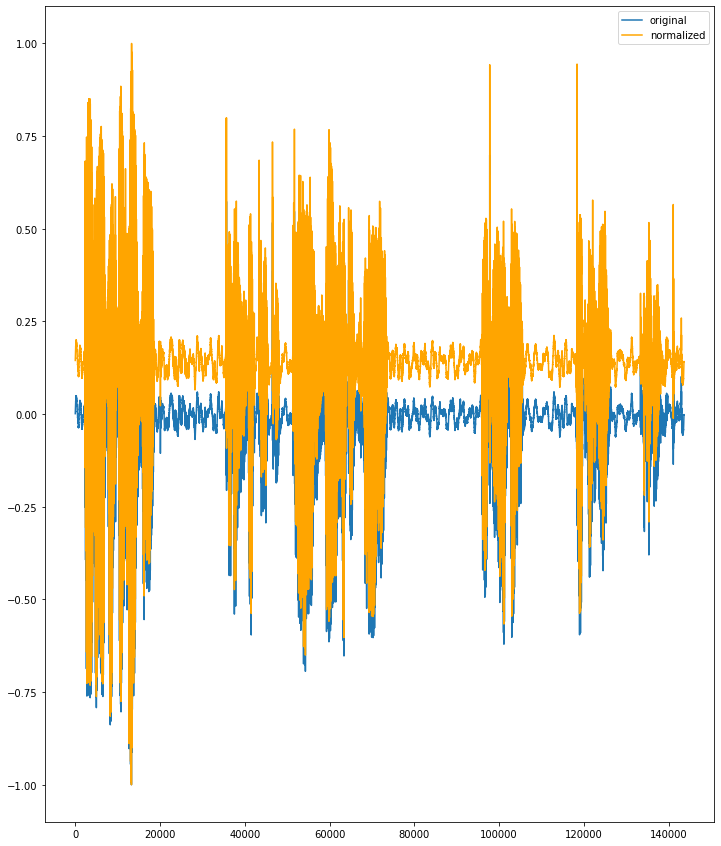

In [8]:
#Visualizing one audio waveform before and after normalization and reproducing it
s, sr = torchaudio.load('/content/drive/MyDrive/emodb/wav/08b03Tc.wav')
print(s.shape, normalize(s).shape) #checking that the length remains the same 

#plotting the waveforms
fig, ax = plt.subplots()
ax.plot(s.squeeze(), label = 'original')
ax.plot(normalize(s).squeeze(), label = 'normalized', color = 'orange')
ax.legend()

Audio(s, rate = sr)

DATAFRAME


In [9]:
#Creating a Dataframe with all the audios and increasing the number of data by slicing all of them into 2 seconds signals
CUT = 2 #2 seconds cut
_emotions = { 'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6 } #W = anger, L = boredom, E = disgust, A = anxiety/fear, F = happiness, T = sadness, N = neutral
df = pd.DataFrame()

#iterate over all files in the directory
for _, _, files in os.walk('/content/drive/MyDrive/emodb/wav/'):
  for file in files:
    emotion = file[5]
    sign, sr = torchaudio.load(os.path.join('/content/drive/MyDrive/emodb/wav/',file)) #loading the waveforms
    samples = sign.size(-1) #length in frames or samples
    seconds = samples/sr #length signal in seconds

    #normalize audio signal between -1 and 1
    sign = normalize(sign)

    #if the signals are smaller than the CUT, pad them with zeroes until they reach desired length
    if seconds < CUT: 
      signal = f.pad(sign,(0, CUT*sr-samples))  #pad until reaches desired dim
      data = [signal.size(-1)/sr, signal.size(-1), emotion, signal, file]
      df = df.append(pd.Series(data, index = ["seconds","numframes","emotion","signal","filename"]), ignore_index=True) #append signal and relevant info to the df
    
    #if the signals are longer then 2 seconds, slice them into 2 seconds signals, dropping the last frames if necessary
    else:
      count = 0
      while seconds - count >= CUT:
        data = [CUT, CUT*sr, emotion, sign[:,count*sr : sr*(CUT+count)], file + str(count)]
        df = df.append(pd.Series(data, index = ["seconds","numframes","emotion","signal","filename"]), ignore_index=True)

        count = count + CUT

df['emotion'] = df['emotion'].map(_emotions)   #map label dict with identifier found in the filename for classification
df

seconds  numframes  emotion  \
0        2.0    32000.0        4   
1        2.0    32000.0        5   
2        2.0    32000.0        3   
3        2.0    32000.0        0   
4        2.0    32000.0        5   
..       ...        ...      ...   
585      2.0    32000.0        1   
586      2.0    32000.0        5   
587      2.0    32000.0        4   
588      2.0    32000.0        0   
589      2.0    32000.0        5   

                                                signal      filename  
0    [[tensor(0.0345), tensor(0.0341), tensor(0.034...  03a05Fc.wav0  
1    [[tensor(0.2347), tensor(0.2347), tensor(0.234...  03a04Ta.wav0  
2    [[tensor(-0.0067), tensor(-0.0064), tensor(-0....  03a05Aa.wav0  
3    [[tensor(-0.1286), tensor(-0.1279), tensor(-0....  03a02Wb.wav0  
4    [[tensor(0.0583), tensor(0.0581), tensor(0.058...  03b09Tc.wav0  
..                                                 ...           ...  
585  [[tensor(0.1182), tensor(0.1187), tensor(0.118...  16b10Lb.wav0  
586  [[tensor(-0.0954), tensor(-0.0963), tensor(-0....  16b10Tb.wav0  
587  [[tensor(-0.3330), tensor(-0.3332), tensor(-0....  16b10Fb.wav0  
588  [[tensor(-0.2524), tensor(-0.2519), tensor(-0....  16b10Wb.wav0  
589  [[tensor(-0.2215), tensor(-0.2205), tensor(-0....  16b10Td.wav0  

[590 rows x 5 columns]

In [10]:
#Counting how the label classes are distributed in the dataset, in order to counter data imbalance later
freq = df['emotion'].value_counts()
print(freq)
class_weights = torch.tensor([freq[0]/len(df),freq[1]/len(df),freq[2]/len(df),freq[3]/len(df),freq[4]/len(df),freq[5]/len(df),freq[6]/len(df)], device = device)
print(class_weights)

0    133
5     93
1     87
6     79
4     71
3     70
2     57
Name: emotion, dtype: int64
tensor([0.2254, 0.1475, 0.0966, 0.1186, 0.1203, 0.1576, 0.1339],
       device='cuda:0', dtype=torch.float64)


MEL-FREQUENCY CEPSTRAL COEFFICIENTS (MFCCs)

In [11]:
#Parameters for the mel-spectrogram and MFCCs computation
n_fft = 1024
win_length = int(sr*64/1000)    #64 ms 
hop_length = int(sr*16/1000)    #16 ms
n_mels = 128
n_mfcc = 40

#defining the function to retrieve the MFC coefficients
mfcc_transform = T.MFCC(sample_rate = sr, n_mfcc = n_mfcc, log_mels = True, melkwargs={"n_fft": n_fft,
                                                                             "n_mels": n_mels,
                                                                             "hop_length": hop_length,
                                                                             "mel_scale": "htk",
                                                                             'f_min': 40, #HZ
                                                                             'f_max': 7600})

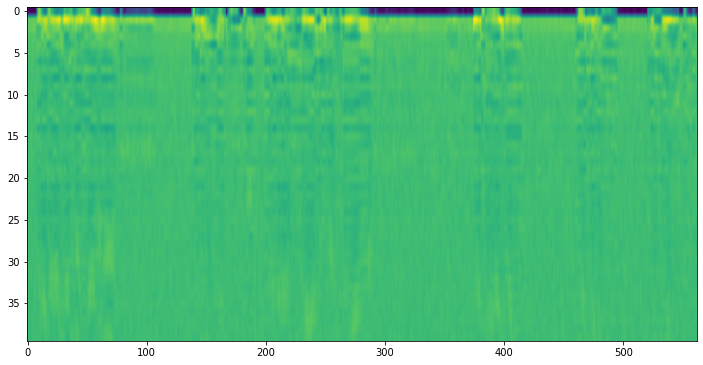

In [12]:
#Applying the transform on a random example
mfcc = mfcc_transform(s)

#Plotting the MFCCs as image, as they are input to the network
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(mfcc.squeeze())
ax.set_aspect(7)
plt.show()

DATASET 

In [13]:
#DATASET
#Standard pytorch definition of the Dataset class, customized to read the DataFrame and return the inputs and labels for the model
class EmodbDataset(Dataset): 
    def __init__(self, df = None, transform=None):
      self.df = df
      self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        waveform = self.df.loc[idx,'signal'] #locating the signal 
        mfcc = mfcc_transform(waveform).to(device) #transforming it and sending it to the GPU
        emotion = self.df.loc[idx,'emotion'] #locating the label/class/emotion
        emotion = torch.tensor(emotion, dtype = int, device = device) #creating a tensor in the GPU

        #Applying transformation, if necessary
        if self.transform:
            sample=self.transform(mfcc)
        
        return mfcc, emotion

The image size in the dataset is torch.Size([1, 40, 126]) and the emotion is size torch.Size([])
The emotion of this audio is the 4


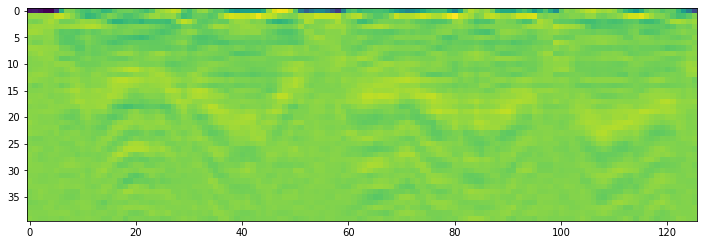

In [14]:
#Initializing the dataset
emodb = EmodbDataset(df)
#Printing a random example to see if everything is correct
example , emotion = random.choice(emodb)
print(f"The image size in the dataset is {example.shape} and the emotion is size {emotion.shape}") #printing the size of the tensors returned by the dataset

#plotting the MFCCs
plt.imshow(example.squeeze().cpu())

print(f"The emotion of this audio is the {emotion}")

REINITIALIZING DATASET AFTER THE TRASFORMATION AND TRAIN/VAL SPLIT

In [15]:
#TRAIN TEST SPLIT
train_size = int(0.8 * len(emodb))
test_size = len(emodb) - train_size

#Splitting the dataset in validation (20%) and train (80%)
train_dataset, test_dataset = torch.utils.data.random_split(emodb, [train_size, test_size])

print(f"Lenght of the training dataset is {len(train_dataset)} items")
print(f"Lenght of the validation dataset is {len(test_dataset)} items")
# Shapes of the dataset
print(f"The shape of the first mfcc image in the test dataset is {train_dataset[0][0].shape}")
print(f"The shape of the label emotion of the first audio in the train dataset is {train_dataset[0][1].shape}")
print(f"The shape of the first mfcc image in the validation dataset is {test_dataset[0][0].shape}")
print(f"The shape of the label emotion of the first audio in the validation dataset is {test_dataset[0][1].shape}")


Lenght of the training dataset is 472 items
Lenght of the validation dataset is 118 items
The shape of the first mfcc image in the test dataset is torch.Size([1, 40, 126])
The shape of the label emotion of the first audio in the train dataset is torch.Size([])
The shape of the first mfcc image in the validation dataset is torch.Size([1, 40, 126])
The shape of the label emotion of the first audio in the validation dataset is torch.Size([])


MODEL

In [16]:
#Function that calculates the correct padding for all the convolutions in the model
def calc_padding(k1,k2,h,w):
  o1 = h
  o2 = w
  s=1
  p1 = (s*(o1-1) + k1-h)//2
  p2 = (s*(o2-1) + k2-w)//2
  return p1, p2

In [17]:
#Calculate the correct padding for all convolutions
h = example.size(1)
w = example.size(2)
print(f"Padding needed for the convolutions in the Parallel Paths are {calc_padding(11,1,h,w),calc_padding(1,9,h,w),calc_padding(3,3,h,w)}")
print(f"Padding needed for the convolution in the Feature Learning is {calc_padding(1,1,h,w)}")

Padding needed for the convolutions in the Parallel Paths are ((5, 0), (0, 4), (1, 1))
Padding needed for the convolution in the Feature Learning is (0, 0)


In [18]:
#CONVOLUTIONAL NEURAL NETWORK
class ParallelPaths(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_pp1 = nn.Conv2d(padding = calc_padding(11,1,h,w), stride= 1, in_channels=1, out_channels=32,padding_mode= 'replicate', kernel_size=(11,1))
        self.conv_pp2 = nn.Conv2d(padding = calc_padding(1,9,h,w), stride= 1, in_channels=1, out_channels=32,padding_mode= 'replicate', kernel_size=(1,9))
        self.conv_pp3 = nn.Conv2d(padding = calc_padding(3,3,h,w), stride= 1, in_channels=1, out_channels=32,padding_mode= 'replicate', kernel_size=(3,3))
        self.batch_norm_pp = nn.BatchNorm2d(32)
        self.relu_pp = nn.PReLU()
        self.avg = nn.AvgPool2d( kernel_size = 1, stride =1 ) #in the paper kernel_size is 2

    def forward(self, x):
        start=x
        #first path
        x1 = self.conv_pp1(start)
        x1 = self.batch_norm_pp(x1)
        x1 = self.relu_pp(x1)
        x1 = self.avg(x1)
        x1 = x1 + start #skip connection for better gradient propagation
        #second path
        x2 = self.conv_pp2(start)
        x2 = self.batch_norm_pp(x2)
        x2 = self.relu_pp(x2)
        x2 = self.avg(x2)
        x2 = x2 + start
        #third path
        x3 = self.conv_pp3(start)
        x3 = self.batch_norm_pp(x3)
        x3 = self.relu_pp(x3)
        x3 = self.avg(x3)
        x3 = x3 + start
        #concatenate tensor along last dimension
        x = torch.cat((x1,x2,x3),-1) 
        return x

class FeatureExtractor(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_fe1 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=32, out_channels=64,padding_mode= 'replicate', kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe2 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=64, out_channels=96,padding_mode= 'replicate', kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe3 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=96, out_channels=128, padding_mode= 'replicate',kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe4 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=128, out_channels=160,padding_mode= 'replicate', kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe5 = nn.Conv2d(padding = calc_padding(1,1,h,w),in_channels=160, out_channels=320,padding_mode= 'replicate', kernel_size=(1,1), stride=(1,1), bias = False)
        self.relu_fe = nn.PReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(96)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(160)
        self.bn5 = nn.BatchNorm2d(320)
        self.avg2 = nn.AvgPool2d(padding=0 , kernel_size =(1,1), stride =1)
        self.avg1 = nn.AvgPool2d(padding=0 , kernel_size =(2,2), stride =1)

    def forward(self, x):
      
      x = self.conv_fe1(x)
      x = self.bn1(x)
      x = self.relu_fe(x)
      x = self.avg2(x)
      
      x = self.conv_fe2(x)
      x = self.bn2(x)
      x = self.relu_fe(x)
      x = self.avg2(x)
      
      x = self.conv_fe3(x)
      x = self.bn3(x)
      x = self.relu_fe(x)
      x = self.avg2(x)
    
      x = self.conv_fe4(x)
      x = self.bn4(x)
      x = self.relu_fe(x)
      x = self.avg2(x)
    
      x = self.conv_fe5(x)
      x = self.bn5(x)
      x = self.relu_fe(x)
      x = x.mean([2,3]) #global average pooling
      
      return x

class CNN(nn.Module):
    """
    Implementation of the CNN as described in the paper.
    """
    def __init__(self):
        super().__init__()

        self.pp = ParallelPaths()
        self.fe = FeatureExtractor()
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features = 320, out_features = 7)


    def forward(self, x):
      x = self.pp(x)
      x = self.fe(x)
      x = self.dropout(x)
      x = self.fc(x) 

      return x

In [19]:
from torchsummary import summary
#Initialize the Convolutional Neural Network
cnn_net = CNN()
cnn_net = cnn_net.to(device)
#Visualize it by sending a random input which as the same shape of the data
summary(cnn_net,(1,h,w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 40, 126]             384
       BatchNorm2d-2          [-1, 32, 40, 126]              64
             PReLU-3          [-1, 32, 40, 126]               1
         AvgPool2d-4          [-1, 32, 40, 126]               0
            Conv2d-5          [-1, 32, 40, 126]             320
       BatchNorm2d-6          [-1, 32, 40, 126]              64
             PReLU-7          [-1, 32, 40, 126]               1
         AvgPool2d-8          [-1, 32, 40, 126]               0
            Conv2d-9          [-1, 32, 40, 126]             320
      BatchNorm2d-10          [-1, 32, 40, 126]              64
            PReLU-11          [-1, 32, 40, 126]               1
        AvgPool2d-12          [-1, 32, 40, 126]               0
    ParallelPaths-13          [-1, 32, 40, 378]               0
           Conv2d-14          [-1, 64, 

DATALOADER


The valued stored in the tensor of the label of the first signal is 3
The size of the batch of images is torch.Size([32, 1, 40, 126])
The size of the batch of labels is torch.Size([32])


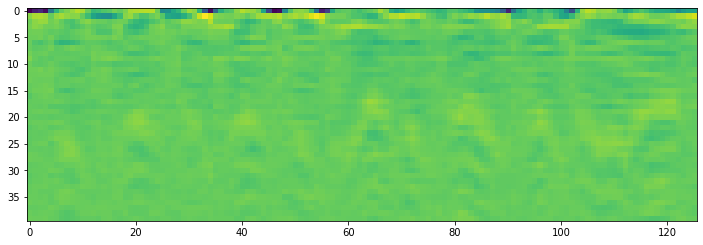

In [21]:
#DATALOADER
#Initializing the Dataloader and setting the size of each batch
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 
validation_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

#Checking that everything is fine in the Dataloader
mfcc, train_labels = next(iter(train_dataloader)) #iterate in the Dataloader
#Visualize the first input image mfcc 
plt.imshow(mfcc[0].squeeze().cpu())
#Print first label emotion
print(f"The valued stored in the tensor of the label of the first signal is {train_labels[0]}")
#Print shapes of data inside Dataloader
print(f"The size of the batch of images is {mfcc.size()}")
print(f"The size of the batch of labels is {train_labels.size()}")

LOSS

In [22]:
###FOCAL LOSS
# https://github.com/VSainteuf/pytorch-psetae/blob/master/learning/focal_loss.py
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = f.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

METRICS AND IGNITE

In [23]:
from ignite.engine import Engine,create_supervised_evaluator,Events,create_supervised_trainer
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import ModelCheckpoint, global_step_from_engine
from glob import glob
from ignite.metrics import Precision, Recall, Loss

In [30]:
#TRAINING with ignite library
LR = 5e-5 #learning rate

#METRICS
#In the paper they use 3 metrics UA, WA, F1
metric0 = Precision(average=True)       #UA
metric1 = Precision(average='weighted') #WA
precision = Precision(average=False)
recall = Recall(average=False)
F1 = ((precision * recall * 2 / (precision + recall)).mean())*100 #F1

#LOSS CRITERIONS 
#In the paper they try 2 criterions CE and F-Loss
criterion = torch.nn.CrossEntropyLoss()
criterion2 = FocalLoss(gamma=2, alpha = class_weights) #in the paper they don't use alpha, we use it for addresisng class imbalance

#OPTIMIZER
optimizer = optim.Adam(cnn_net.parameters(), lr = LR, weight_decay=1e-6)

#SCHEDULER
scheduler = sc.ExponentialLR(optimizer, gamma = 0.98) #previously was 0.86
#scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=int(len(train_dataloader)), epochs = 300 , anneal_strategy='linear')

# Accuracy and loss metrics are defined
val_metrics = {
  "accuracy": metric0*100,
  "weighted acc": metric1*100,
  "ce_loss": Loss(criterion),
  "focal_loss": Loss(criterion2) }


TRAINING


In [31]:
#Training/Validation functions, events and handlers are adapted from the IGNITE library documentation
trainer = create_supervised_trainer(cnn_net, optimizer, criterion2, device)
train_evaluator = create_supervised_evaluator(cnn_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(cnn_net, metrics=val_metrics, device=device)

# Attach metrics to the evaluators
for name, metric in val_metrics.items():
    metric.attach(train_evaluator, name)

for name, metric in val_metrics.items():
    metric.attach(val_evaluator, name)

#attach F1 to evaluators
F1.attach(train_evaluator, "F1_score")
F1.attach(val_evaluator, "F1_score")

In [32]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_dataloader)
    metrics = train_evaluator.state.metrics
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f}% Avg F1: {metrics['F1_score']:.2f}% Avg weig accuracy: {metrics['weighted acc']:.2f}%  Avg Focal loss: {metrics['focal_loss']:.2f}  Avg CE loss: {metrics['ce_loss']:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(validation_loader)
    metrics = val_evaluator.state.metrics
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f}% Avg F1: {metrics['F1_score']:.2f}% Avg weig accuracy: {metrics['weighted acc']:.2f}%  Avg Focal loss: {metrics['focal_loss']:.2f}  Avg CE loss: {metrics['ce_loss']:.2f}")


In [33]:
ProgressBar().attach(trainer, output_transform=lambda x: {'batch loss': x})

In [34]:
# Score function to select relevant metric, here f1
# Score function to select relevant metric, here f1
def score_function(engine):
    return engine.state.metrics["weighted acc"]

# Checkpoint to store n_saved best models wrt score function
model_checkpoint = ModelCheckpoint(
    "SER",
    n_saved=1,
    filename_prefix="best",
    score_function=score_function,
    score_name="weighted acc",
    global_step_transform=global_step_from_engine(trainer),
)
  
# Save the model (if relevant) every epoch completed of evaluator
val_evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {"model": cnn_net});

In [35]:
trainer.run(train_dataloader, max_epochs=300)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[1] Avg accuracy: 34.62% Avg F1: nan% Avg weig accuracy: 41.18%  Avg Focal loss: 0.21  Avg CE loss: 1.91
Validation Results - Epoch[1] Avg accuracy: 30.75% Avg F1: nan% Avg weig accuracy: 35.48%  Avg Focal loss: 0.20  Avg CE loss: 1.91


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[2] Avg accuracy: 29.96% Avg F1: nan% Avg weig accuracy: 34.77%  Avg Focal loss: 0.18  Avg CE loss: 1.76
Validation Results - Epoch[2] Avg accuracy: 35.38% Avg F1: nan% Avg weig accuracy: 36.18%  Avg Focal loss: 0.17  Avg CE loss: 1.78


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[3] Avg accuracy: 21.66% Avg F1: nan% Avg weig accuracy: 27.65%  Avg Focal loss: 0.16  Avg CE loss: 1.65
Validation Results - Epoch[3] Avg accuracy: 19.78% Avg F1: nan% Avg weig accuracy: 23.01%  Avg Focal loss: 0.15  Avg CE loss: 1.68


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[4] Avg accuracy: 21.87% Avg F1: nan% Avg weig accuracy: 27.95%  Avg Focal loss: 0.14  Avg CE loss: 1.57
Validation Results - Epoch[4] Avg accuracy: 18.81% Avg F1: nan% Avg weig accuracy: 21.88%  Avg Focal loss: 0.14  Avg CE loss: 1.62


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[5] Avg accuracy: 23.83% Avg F1: nan% Avg weig accuracy: 29.53%  Avg Focal loss: 0.13  Avg CE loss: 1.50
Validation Results - Epoch[5] Avg accuracy: 18.22% Avg F1: nan% Avg weig accuracy: 21.01%  Avg Focal loss: 0.13  Avg CE loss: 1.56


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[6] Avg accuracy: 30.00% Avg F1: nan% Avg weig accuracy: 34.69%  Avg Focal loss: 0.12  Avg CE loss: 1.43
Validation Results - Epoch[6] Avg accuracy: 26.45% Avg F1: nan% Avg weig accuracy: 30.57%  Avg Focal loss: 0.12  Avg CE loss: 1.50


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[7] Avg accuracy: 26.51% Avg F1: nan% Avg weig accuracy: 31.88%  Avg Focal loss: 0.11  Avg CE loss: 1.41
Validation Results - Epoch[7] Avg accuracy: 23.45% Avg F1: nan% Avg weig accuracy: 26.89%  Avg Focal loss: 0.12  Avg CE loss: 1.48


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[8] Avg accuracy: 29.53% Avg F1: nan% Avg weig accuracy: 34.55%  Avg Focal loss: 0.11  Avg CE loss: 1.37
Validation Results - Epoch[8] Avg accuracy: 21.69% Avg F1: nan% Avg weig accuracy: 24.72%  Avg Focal loss: 0.12  Avg CE loss: 1.44


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[9] Avg accuracy: 42.64% Avg F1: nan% Avg weig accuracy: 44.93%  Avg Focal loss: 0.11  Avg CE loss: 1.36
Validation Results - Epoch[9] Avg accuracy: 24.23% Avg F1: nan% Avg weig accuracy: 27.76%  Avg Focal loss: 0.11  Avg CE loss: 1.42


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[10] Avg accuracy: 37.25% Avg F1: nan% Avg weig accuracy: 40.71%  Avg Focal loss: 0.10  Avg CE loss: 1.31
Validation Results - Epoch[10] Avg accuracy: 44.14% Avg F1: nan% Avg weig accuracy: 49.51%  Avg Focal loss: 0.11  Avg CE loss: 1.39


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[11] Avg accuracy: 40.76% Avg F1: nan% Avg weig accuracy: 43.63%  Avg Focal loss: 0.10  Avg CE loss: 1.30
Validation Results - Epoch[11] Avg accuracy: 46.42% Avg F1: nan% Avg weig accuracy: 52.05%  Avg Focal loss: 0.11  Avg CE loss: 1.38


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[12] Avg accuracy: 33.05% Avg F1: nan% Avg weig accuracy: 37.96%  Avg Focal loss: 0.10  Avg CE loss: 1.28
Validation Results - Epoch[12] Avg accuracy: 40.95% Avg F1: nan% Avg weig accuracy: 45.50%  Avg Focal loss: 0.10  Avg CE loss: 1.35


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[13] Avg accuracy: 37.70% Avg F1: nan% Avg weig accuracy: 41.76%  Avg Focal loss: 0.09  Avg CE loss: 1.26
Validation Results - Epoch[13] Avg accuracy: 46.06% Avg F1: nan% Avg weig accuracy: 51.43%  Avg Focal loss: 0.10  Avg CE loss: 1.33


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[14] Avg accuracy: 38.47% Avg F1: nan% Avg weig accuracy: 42.29%  Avg Focal loss: 0.09  Avg CE loss: 1.24
Validation Results - Epoch[14] Avg accuracy: 43.69% Avg F1: nan% Avg weig accuracy: 48.85%  Avg Focal loss: 0.10  Avg CE loss: 1.33


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[15] Avg accuracy: 41.04% Avg F1: nan% Avg weig accuracy: 44.86%  Avg Focal loss: 0.09  Avg CE loss: 1.23
Validation Results - Epoch[15] Avg accuracy: 45.22% Avg F1: nan% Avg weig accuracy: 50.00%  Avg Focal loss: 0.10  Avg CE loss: 1.30


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[16] Avg accuracy: 41.45% Avg F1: nan% Avg weig accuracy: 45.23%  Avg Focal loss: 0.09  Avg CE loss: 1.23
Validation Results - Epoch[16] Avg accuracy: 46.35% Avg F1: nan% Avg weig accuracy: 51.37%  Avg Focal loss: 0.09  Avg CE loss: 1.30


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[17] Avg accuracy: 42.94% Avg F1: nan% Avg weig accuracy: 46.71%  Avg Focal loss: 0.09  Avg CE loss: 1.21
Validation Results - Epoch[17] Avg accuracy: 43.79% Avg F1: nan% Avg weig accuracy: 48.49%  Avg Focal loss: 0.09  Avg CE loss: 1.28


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[18] Avg accuracy: 39.93% Avg F1: nan% Avg weig accuracy: 44.05%  Avg Focal loss: 0.09  Avg CE loss: 1.22
Validation Results - Epoch[18] Avg accuracy: 43.38% Avg F1: nan% Avg weig accuracy: 47.99%  Avg Focal loss: 0.09  Avg CE loss: 1.28


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[19] Avg accuracy: 43.70% Avg F1: nan% Avg weig accuracy: 47.36%  Avg Focal loss: 0.08  Avg CE loss: 1.19
Validation Results - Epoch[19] Avg accuracy: 41.66% Avg F1: nan% Avg weig accuracy: 46.55%  Avg Focal loss: 0.09  Avg CE loss: 1.26


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[20] Avg accuracy: 43.35% Avg F1: nan% Avg weig accuracy: 47.27%  Avg Focal loss: 0.08  Avg CE loss: 1.18
Validation Results - Epoch[20] Avg accuracy: 46.98% Avg F1: nan% Avg weig accuracy: 52.01%  Avg Focal loss: 0.09  Avg CE loss: 1.25


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[21] Avg accuracy: 40.76% Avg F1: nan% Avg weig accuracy: 45.06%  Avg Focal loss: 0.08  Avg CE loss: 1.16
Validation Results - Epoch[21] Avg accuracy: 45.77% Avg F1: nan% Avg weig accuracy: 50.67%  Avg Focal loss: 0.09  Avg CE loss: 1.23


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[22] Avg accuracy: 56.68% Avg F1: nan% Avg weig accuracy: 56.45%  Avg Focal loss: 0.08  Avg CE loss: 1.17
Validation Results - Epoch[22] Avg accuracy: 44.83% Avg F1: nan% Avg weig accuracy: 49.53%  Avg Focal loss: 0.09  Avg CE loss: 1.23


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[23] Avg accuracy: 44.44% Avg F1: nan% Avg weig accuracy: 48.61%  Avg Focal loss: 0.08  Avg CE loss: 1.14
Validation Results - Epoch[23] Avg accuracy: 45.96% Avg F1: nan% Avg weig accuracy: 50.77%  Avg Focal loss: 0.08  Avg CE loss: 1.20


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[24] Avg accuracy: 44.95% Avg F1: nan% Avg weig accuracy: 49.17%  Avg Focal loss: 0.08  Avg CE loss: 1.15
Validation Results - Epoch[24] Avg accuracy: 39.22% Avg F1: nan% Avg weig accuracy: 43.63%  Avg Focal loss: 0.08  Avg CE loss: 1.21


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[25] Avg accuracy: 43.48% Avg F1: nan% Avg weig accuracy: 47.32%  Avg Focal loss: 0.08  Avg CE loss: 1.12
Validation Results - Epoch[25] Avg accuracy: 42.60% Avg F1: nan% Avg weig accuracy: 47.42%  Avg Focal loss: 0.08  Avg CE loss: 1.20


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[26] Avg accuracy: 59.64% Avg F1: nan% Avg weig accuracy: 61.74%  Avg Focal loss: 0.07  Avg CE loss: 1.11
Validation Results - Epoch[26] Avg accuracy: 58.67% Avg F1: nan% Avg weig accuracy: 61.30%  Avg Focal loss: 0.08  Avg CE loss: 1.17


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[27] Avg accuracy: 59.55% Avg F1: nan% Avg weig accuracy: 58.93%  Avg Focal loss: 0.08  Avg CE loss: 1.12
Validation Results - Epoch[27] Avg accuracy: 46.63% Avg F1: nan% Avg weig accuracy: 51.73%  Avg Focal loss: 0.08  Avg CE loss: 1.19


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[28] Avg accuracy: 74.37% Avg F1: 50.14% Avg weig accuracy: 72.23%  Avg Focal loss: 0.08  Avg CE loss: 1.11
Validation Results - Epoch[28] Avg accuracy: 46.65% Avg F1: nan% Avg weig accuracy: 51.43%  Avg Focal loss: 0.08  Avg CE loss: 1.16


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[29] Avg accuracy: 45.87% Avg F1: nan% Avg weig accuracy: 49.74%  Avg Focal loss: 0.07  Avg CE loss: 1.10
Validation Results - Epoch[29] Avg accuracy: 42.24% Avg F1: nan% Avg weig accuracy: 47.11%  Avg Focal loss: 0.08  Avg CE loss: 1.17


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[30] Avg accuracy: 73.03% Avg F1: 50.92% Avg weig accuracy: 70.59%  Avg Focal loss: 0.07  Avg CE loss: 1.08
Validation Results - Epoch[30] Avg accuracy: 46.02% Avg F1: nan% Avg weig accuracy: 50.64%  Avg Focal loss: 0.08  Avg CE loss: 1.15


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[31] Avg accuracy: 72.79% Avg F1: 47.67% Avg weig accuracy: 70.68%  Avg Focal loss: 0.08  Avg CE loss: 1.09
Validation Results - Epoch[31] Avg accuracy: 60.94% Avg F1: nan% Avg weig accuracy: 63.50%  Avg Focal loss: 0.08  Avg CE loss: 1.15


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[32] Avg accuracy: 45.51% Avg F1: nan% Avg weig accuracy: 49.66%  Avg Focal loss: 0.07  Avg CE loss: 1.08
Validation Results - Epoch[32] Avg accuracy: 56.51% Avg F1: nan% Avg weig accuracy: 55.97%  Avg Focal loss: 0.08  Avg CE loss: 1.14


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[33] Avg accuracy: 64.43% Avg F1: 51.70% Avg weig accuracy: 64.50%  Avg Focal loss: 0.07  Avg CE loss: 1.08
Validation Results - Epoch[33] Avg accuracy: 72.27% Avg F1: 47.78% Avg weig accuracy: 69.62%  Avg Focal loss: 0.08  Avg CE loss: 1.14


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[34] Avg accuracy: 71.77% Avg F1: 50.68% Avg weig accuracy: 69.63%  Avg Focal loss: 0.07  Avg CE loss: 1.05
Validation Results - Epoch[34] Avg accuracy: 62.20% Avg F1: nan% Avg weig accuracy: 62.12%  Avg Focal loss: 0.07  Avg CE loss: 1.12


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[35] Avg accuracy: 61.25% Avg F1: 50.97% Avg weig accuracy: 61.68%  Avg Focal loss: 0.07  Avg CE loss: 1.05
Validation Results - Epoch[35] Avg accuracy: 68.27% Avg F1: 44.96% Avg weig accuracy: 65.11%  Avg Focal loss: 0.07  Avg CE loss: 1.13


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[36] Avg accuracy: 57.28% Avg F1: nan% Avg weig accuracy: 57.74%  Avg Focal loss: 0.07  Avg CE loss: 1.05
Validation Results - Epoch[36] Avg accuracy: 61.75% Avg F1: nan% Avg weig accuracy: 61.90%  Avg Focal loss: 0.07  Avg CE loss: 1.13


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[37] Avg accuracy: 72.23% Avg F1: 55.81% Avg weig accuracy: 70.99%  Avg Focal loss: 0.07  Avg CE loss: 1.04
Validation Results - Epoch[37] Avg accuracy: 78.12% Avg F1: 54.82% Avg weig accuracy: 75.89%  Avg Focal loss: 0.07  Avg CE loss: 1.10


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[38] Avg accuracy: 70.26% Avg F1: 54.17% Avg weig accuracy: 69.30%  Avg Focal loss: 0.07  Avg CE loss: 1.03
Validation Results - Epoch[38] Avg accuracy: 78.20% Avg F1: 54.15% Avg weig accuracy: 76.21%  Avg Focal loss: 0.07  Avg CE loss: 1.09


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[39] Avg accuracy: 72.50% Avg F1: 51.70% Avg weig accuracy: 70.56%  Avg Focal loss: 0.07  Avg CE loss: 1.02
Validation Results - Epoch[39] Avg accuracy: 74.44% Avg F1: 50.05% Avg weig accuracy: 72.59%  Avg Focal loss: 0.08  Avg CE loss: 1.13


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[40] Avg accuracy: 68.64% Avg F1: 55.30% Avg weig accuracy: 68.21%  Avg Focal loss: 0.07  Avg CE loss: 1.02
Validation Results - Epoch[40] Avg accuracy: 56.46% Avg F1: nan% Avg weig accuracy: 58.51%  Avg Focal loss: 0.07  Avg CE loss: 1.12


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[41] Avg accuracy: 74.96% Avg F1: 54.36% Avg weig accuracy: 73.02%  Avg Focal loss: 0.06  Avg CE loss: 1.00
Validation Results - Epoch[41] Avg accuracy: 60.33% Avg F1: nan% Avg weig accuracy: 60.30%  Avg Focal loss: 0.07  Avg CE loss: 1.08


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[42] Avg accuracy: 74.90% Avg F1: 55.64% Avg weig accuracy: 72.92%  Avg Focal loss: 0.06  Avg CE loss: 1.01
Validation Results - Epoch[42] Avg accuracy: 62.88% Avg F1: nan% Avg weig accuracy: 65.76%  Avg Focal loss: 0.07  Avg CE loss: 1.09


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[43] Avg accuracy: 73.24% Avg F1: 53.62% Avg weig accuracy: 71.39%  Avg Focal loss: 0.06  Avg CE loss: 1.00
Validation Results - Epoch[43] Avg accuracy: 77.62% Avg F1: 51.76% Avg weig accuracy: 75.47%  Avg Focal loss: 0.07  Avg CE loss: 1.09


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[44] Avg accuracy: 72.07% Avg F1: 59.03% Avg weig accuracy: 71.13%  Avg Focal loss: 0.06  Avg CE loss: 1.00
Validation Results - Epoch[44] Avg accuracy: 73.87% Avg F1: 56.07% Avg weig accuracy: 71.88%  Avg Focal loss: 0.07  Avg CE loss: 1.06


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[45] Avg accuracy: 67.19% Avg F1: 56.23% Avg weig accuracy: 68.40%  Avg Focal loss: 0.07  Avg CE loss: 1.04
Validation Results - Epoch[45] Avg accuracy: 69.18% Avg F1: 57.29% Avg weig accuracy: 69.23%  Avg Focal loss: 0.07  Avg CE loss: 1.08


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[46] Avg accuracy: 67.64% Avg F1: 53.20% Avg weig accuracy: 67.05%  Avg Focal loss: 0.06  Avg CE loss: 0.99
Validation Results - Epoch[46] Avg accuracy: 64.32% Avg F1: 47.11% Avg weig accuracy: 65.17%  Avg Focal loss: 0.07  Avg CE loss: 1.08


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[47] Avg accuracy: 71.33% Avg F1: 59.65% Avg weig accuracy: 70.85%  Avg Focal loss: 0.06  Avg CE loss: 1.00
Validation Results - Epoch[47] Avg accuracy: 74.69% Avg F1: 58.01% Avg weig accuracy: 72.83%  Avg Focal loss: 0.07  Avg CE loss: 1.05


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[48] Avg accuracy: 74.65% Avg F1: 56.86% Avg weig accuracy: 73.18%  Avg Focal loss: 0.06  Avg CE loss: 0.97
Validation Results - Epoch[48] Avg accuracy: 69.53% Avg F1: 54.02% Avg weig accuracy: 69.75%  Avg Focal loss: 0.07  Avg CE loss: 1.04


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[49] Avg accuracy: 66.60% Avg F1: 55.65% Avg weig accuracy: 65.89%  Avg Focal loss: 0.06  Avg CE loss: 0.98
Validation Results - Epoch[49] Avg accuracy: 75.56% Avg F1: 51.36% Avg weig accuracy: 73.50%  Avg Focal loss: 0.07  Avg CE loss: 1.08


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[50] Avg accuracy: 73.22% Avg F1: 57.21% Avg weig accuracy: 71.85%  Avg Focal loss: 0.06  Avg CE loss: 0.97
Validation Results - Epoch[50] Avg accuracy: 77.83% Avg F1: 55.32% Avg weig accuracy: 75.55%  Avg Focal loss: 0.06  Avg CE loss: 1.04


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[51] Avg accuracy: 70.44% Avg F1: 59.66% Avg weig accuracy: 69.90%  Avg Focal loss: 0.06  Avg CE loss: 0.97
Validation Results - Epoch[51] Avg accuracy: 72.33% Avg F1: 62.43% Avg weig accuracy: 73.13%  Avg Focal loss: 0.07  Avg CE loss: 1.05


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[52] Avg accuracy: 66.74% Avg F1: 55.91% Avg weig accuracy: 68.60%  Avg Focal loss: 0.07  Avg CE loss: 1.04
Validation Results - Epoch[52] Avg accuracy: 72.42% Avg F1: 61.95% Avg weig accuracy: 72.62%  Avg Focal loss: 0.07  Avg CE loss: 1.08


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[53] Avg accuracy: 74.34% Avg F1: 63.36% Avg weig accuracy: 73.40%  Avg Focal loss: 0.06  Avg CE loss: 0.99
Validation Results - Epoch[53] Avg accuracy: 76.92% Avg F1: 62.02% Avg weig accuracy: 74.92%  Avg Focal loss: 0.07  Avg CE loss: 1.05


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[54] Avg accuracy: 71.95% Avg F1: 60.71% Avg weig accuracy: 70.96%  Avg Focal loss: 0.06  Avg CE loss: 0.95
Validation Results - Epoch[54] Avg accuracy: 74.50% Avg F1: 58.41% Avg weig accuracy: 74.40%  Avg Focal loss: 0.07  Avg CE loss: 1.04


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[55] Avg accuracy: 75.13% Avg F1: 65.13% Avg weig accuracy: 73.87%  Avg Focal loss: 0.06  Avg CE loss: 0.95
Validation Results - Epoch[55] Avg accuracy: 74.33% Avg F1: 62.46% Avg weig accuracy: 73.93%  Avg Focal loss: 0.06  Avg CE loss: 1.02


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[56] Avg accuracy: 69.52% Avg F1: 59.65% Avg weig accuracy: 69.64%  Avg Focal loss: 0.06  Avg CE loss: 0.96
Validation Results - Epoch[56] Avg accuracy: 78.48% Avg F1: 59.92% Avg weig accuracy: 75.91%  Avg Focal loss: 0.06  Avg CE loss: 1.02


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[57] Avg accuracy: 72.79% Avg F1: 65.10% Avg weig accuracy: 72.13%  Avg Focal loss: 0.06  Avg CE loss: 0.96
Validation Results - Epoch[57] Avg accuracy: 75.38% Avg F1: 61.60% Avg weig accuracy: 73.58%  Avg Focal loss: 0.06  Avg CE loss: 1.02


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[58] Avg accuracy: 74.58% Avg F1: 61.30% Avg weig accuracy: 72.85%  Avg Focal loss: 0.06  Avg CE loss: 0.93
Validation Results - Epoch[58] Avg accuracy: 73.17% Avg F1: 56.32% Avg weig accuracy: 73.11%  Avg Focal loss: 0.07  Avg CE loss: 1.04


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[59] Avg accuracy: 71.21% Avg F1: 65.16% Avg weig accuracy: 72.92%  Avg Focal loss: 0.06  Avg CE loss: 0.98
Validation Results - Epoch[59] Avg accuracy: 74.75% Avg F1: 67.98% Avg weig accuracy: 75.48%  Avg Focal loss: 0.06  Avg CE loss: 1.02


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[60] Avg accuracy: 72.03% Avg F1: 59.97% Avg weig accuracy: 71.33%  Avg Focal loss: 0.05  Avg CE loss: 0.93
Validation Results - Epoch[60] Avg accuracy: 71.23% Avg F1: 54.97% Avg weig accuracy: 69.24%  Avg Focal loss: 0.06  Avg CE loss: 1.00


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[61] Avg accuracy: 72.05% Avg F1: 65.31% Avg weig accuracy: 71.38%  Avg Focal loss: 0.05  Avg CE loss: 0.94
Validation Results - Epoch[61] Avg accuracy: 68.26% Avg F1: 58.22% Avg weig accuracy: 68.77%  Avg Focal loss: 0.06  Avg CE loss: 1.01


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[62] Avg accuracy: 76.47% Avg F1: 63.64% Avg weig accuracy: 74.86%  Avg Focal loss: 0.05  Avg CE loss: 0.91
Validation Results - Epoch[62] Avg accuracy: 78.07% Avg F1: 60.08% Avg weig accuracy: 75.87%  Avg Focal loss: 0.06  Avg CE loss: 0.99


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[63] Avg accuracy: 72.95% Avg F1: 60.48% Avg weig accuracy: 72.77%  Avg Focal loss: 0.06  Avg CE loss: 0.95
Validation Results - Epoch[63] Avg accuracy: 76.25% Avg F1: 64.28% Avg weig accuracy: 76.48%  Avg Focal loss: 0.07  Avg CE loss: 1.04


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[64] Avg accuracy: 74.84% Avg F1: 67.15% Avg weig accuracy: 73.98%  Avg Focal loss: 0.05  Avg CE loss: 0.93
Validation Results - Epoch[64] Avg accuracy: 75.89% Avg F1: 61.06% Avg weig accuracy: 74.82%  Avg Focal loss: 0.06  Avg CE loss: 0.99


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[65] Avg accuracy: 78.43% Avg F1: 67.50% Avg weig accuracy: 77.54%  Avg Focal loss: 0.05  Avg CE loss: 0.92
Validation Results - Epoch[65] Avg accuracy: 77.36% Avg F1: 65.28% Avg weig accuracy: 75.65%  Avg Focal loss: 0.06  Avg CE loss: 0.98


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[66] Avg accuracy: 77.02% Avg F1: 71.32% Avg weig accuracy: 76.70%  Avg Focal loss: 0.05  Avg CE loss: 0.92
Validation Results - Epoch[66] Avg accuracy: 73.41% Avg F1: 67.61% Avg weig accuracy: 74.13%  Avg Focal loss: 0.06  Avg CE loss: 0.97


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[67] Avg accuracy: 77.31% Avg F1: 64.13% Avg weig accuracy: 75.90%  Avg Focal loss: 0.05  Avg CE loss: 0.90
Validation Results - Epoch[67] Avg accuracy: 67.59% Avg F1: 57.11% Avg weig accuracy: 68.67%  Avg Focal loss: 0.06  Avg CE loss: 0.97


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[68] Avg accuracy: 78.74% Avg F1: 75.16% Avg weig accuracy: 79.16%  Avg Focal loss: 0.05  Avg CE loss: 0.91
Validation Results - Epoch[68] Avg accuracy: 78.01% Avg F1: 71.41% Avg weig accuracy: 77.43%  Avg Focal loss: 0.06  Avg CE loss: 0.95


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[69] Avg accuracy: 69.65% Avg F1: 60.35% Avg weig accuracy: 71.48%  Avg Focal loss: 0.06  Avg CE loss: 0.99
Validation Results - Epoch[69] Avg accuracy: 65.64% Avg F1: 60.14% Avg weig accuracy: 66.86%  Avg Focal loss: 0.07  Avg CE loss: 1.05


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[70] Avg accuracy: 77.02% Avg F1: 66.41% Avg weig accuracy: 76.04%  Avg Focal loss: 0.05  Avg CE loss: 0.89
Validation Results - Epoch[70] Avg accuracy: 78.81% Avg F1: 62.42% Avg weig accuracy: 76.53%  Avg Focal loss: 0.05  Avg CE loss: 0.95


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[71] Avg accuracy: 76.90% Avg F1: 66.95% Avg weig accuracy: 75.48%  Avg Focal loss: 0.05  Avg CE loss: 0.89
Validation Results - Epoch[71] Avg accuracy: 76.71% Avg F1: 63.62% Avg weig accuracy: 76.61%  Avg Focal loss: 0.06  Avg CE loss: 1.00


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[72] Avg accuracy: 74.39% Avg F1: 66.63% Avg weig accuracy: 73.69%  Avg Focal loss: 0.05  Avg CE loss: 0.90
Validation Results - Epoch[72] Avg accuracy: 80.18% Avg F1: 64.45% Avg weig accuracy: 77.97%  Avg Focal loss: 0.06  Avg CE loss: 0.97


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[73] Avg accuracy: 79.23% Avg F1: 69.80% Avg weig accuracy: 77.61%  Avg Focal loss: 0.05  Avg CE loss: 0.87
Validation Results - Epoch[73] Avg accuracy: 79.13% Avg F1: 65.94% Avg weig accuracy: 78.42%  Avg Focal loss: 0.06  Avg CE loss: 0.96


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[74] Avg accuracy: 77.16% Avg F1: 64.00% Avg weig accuracy: 75.24%  Avg Focal loss: 0.05  Avg CE loss: 0.88
Validation Results - Epoch[74] Avg accuracy: 81.10% Avg F1: 63.12% Avg weig accuracy: 80.11%  Avg Focal loss: 0.06  Avg CE loss: 1.00


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[75] Avg accuracy: 73.96% Avg F1: 65.77% Avg weig accuracy: 75.33%  Avg Focal loss: 0.06  Avg CE loss: 0.94
Validation Results - Epoch[75] Avg accuracy: 77.46% Avg F1: 67.56% Avg weig accuracy: 76.53%  Avg Focal loss: 0.06  Avg CE loss: 0.99


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[76] Avg accuracy: 72.42% Avg F1: 63.43% Avg weig accuracy: 72.95%  Avg Focal loss: 0.05  Avg CE loss: 0.88
Validation Results - Epoch[76] Avg accuracy: 74.16% Avg F1: 65.81% Avg weig accuracy: 73.61%  Avg Focal loss: 0.06  Avg CE loss: 0.94


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[77] Avg accuracy: 75.22% Avg F1: 68.01% Avg weig accuracy: 75.15%  Avg Focal loss: 0.05  Avg CE loss: 0.89
Validation Results - Epoch[77] Avg accuracy: 75.07% Avg F1: 67.31% Avg weig accuracy: 75.34%  Avg Focal loss: 0.06  Avg CE loss: 0.96


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[78] Avg accuracy: 81.00% Avg F1: 69.80% Avg weig accuracy: 78.83%  Avg Focal loss: 0.05  Avg CE loss: 0.87
Validation Results - Epoch[78] Avg accuracy: 70.93% Avg F1: 57.16% Avg weig accuracy: 70.56%  Avg Focal loss: 0.06  Avg CE loss: 0.96


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[79] Avg accuracy: 68.94% Avg F1: 59.28% Avg weig accuracy: 68.19%  Avg Focal loss: 0.06  Avg CE loss: 0.92
Validation Results - Epoch[79] Avg accuracy: 72.78% Avg F1: 52.29% Avg weig accuracy: 71.64%  Avg Focal loss: 0.07  Avg CE loss: 1.07


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[80] Avg accuracy: 73.16% Avg F1: 64.16% Avg weig accuracy: 74.07%  Avg Focal loss: 0.06  Avg CE loss: 0.92
Validation Results - Epoch[80] Avg accuracy: 76.11% Avg F1: 68.41% Avg weig accuracy: 76.61%  Avg Focal loss: 0.06  Avg CE loss: 1.00


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[81] Avg accuracy: 74.43% Avg F1: 64.11% Avg weig accuracy: 72.61%  Avg Focal loss: 0.05  Avg CE loss: 0.88
Validation Results - Epoch[81] Avg accuracy: 75.48% Avg F1: 55.27% Avg weig accuracy: 75.17%  Avg Focal loss: 0.07  Avg CE loss: 1.02


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[82] Avg accuracy: 80.44% Avg F1: 72.81% Avg weig accuracy: 79.70%  Avg Focal loss: 0.05  Avg CE loss: 0.84
Validation Results - Epoch[82] Avg accuracy: 74.82% Avg F1: 64.71% Avg weig accuracy: 73.62%  Avg Focal loss: 0.05  Avg CE loss: 0.91


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[83] Avg accuracy: 78.66% Avg F1: 68.27% Avg weig accuracy: 76.47%  Avg Focal loss: 0.05  Avg CE loss: 0.84
Validation Results - Epoch[83] Avg accuracy: 76.20% Avg F1: 60.83% Avg weig accuracy: 76.41%  Avg Focal loss: 0.06  Avg CE loss: 0.97


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[84] Avg accuracy: 76.50% Avg F1: 67.11% Avg weig accuracy: 75.21%  Avg Focal loss: 0.05  Avg CE loss: 0.84
Validation Results - Epoch[84] Avg accuracy: 78.68% Avg F1: 62.63% Avg weig accuracy: 76.85%  Avg Focal loss: 0.06  Avg CE loss: 0.94


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[85] Avg accuracy: 79.02% Avg F1: 67.27% Avg weig accuracy: 77.98%  Avg Focal loss: 0.05  Avg CE loss: 0.86
Validation Results - Epoch[85] Avg accuracy: 80.41% Avg F1: 69.80% Avg weig accuracy: 80.02%  Avg Focal loss: 0.06  Avg CE loss: 0.94


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[86] Avg accuracy: 75.58% Avg F1: 67.91% Avg weig accuracy: 74.31%  Avg Focal loss: 0.05  Avg CE loss: 0.89
Validation Results - Epoch[86] Avg accuracy: 68.28% Avg F1: 56.58% Avg weig accuracy: 68.44%  Avg Focal loss: 0.06  Avg CE loss: 1.01


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[87] Avg accuracy: 80.86% Avg F1: 63.04% Avg weig accuracy: 78.19%  Avg Focal loss: 0.05  Avg CE loss: 0.83
Validation Results - Epoch[87] Avg accuracy: 78.60% Avg F1: 59.22% Avg weig accuracy: 76.86%  Avg Focal loss: 0.06  Avg CE loss: 0.95


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[88] Avg accuracy: 81.51% Avg F1: 78.33% Avg weig accuracy: 81.49%  Avg Focal loss: 0.05  Avg CE loss: 0.86
Validation Results - Epoch[88] Avg accuracy: 77.32% Avg F1: 73.04% Avg weig accuracy: 78.29%  Avg Focal loss: 0.05  Avg CE loss: 0.92


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[89] Avg accuracy: 80.10% Avg F1: 68.91% Avg weig accuracy: 78.65%  Avg Focal loss: 0.04  Avg CE loss: 0.82
Validation Results - Epoch[89] Avg accuracy: 76.63% Avg F1: 62.94% Avg weig accuracy: 74.63%  Avg Focal loss: 0.05  Avg CE loss: 0.90


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[90] Avg accuracy: 69.29% Avg F1: 57.04% Avg weig accuracy: 69.41%  Avg Focal loss: 0.06  Avg CE loss: 0.91
Validation Results - Epoch[90] Avg accuracy: 77.11% Avg F1: 57.85% Avg weig accuracy: 75.96%  Avg Focal loss: 0.06  Avg CE loss: 0.98


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[91] Avg accuracy: 81.11% Avg F1: 78.17% Avg weig accuracy: 80.85%  Avg Focal loss: 0.05  Avg CE loss: 0.84
Validation Results - Epoch[91] Avg accuracy: 77.82% Avg F1: 75.73% Avg weig accuracy: 79.30%  Avg Focal loss: 0.05  Avg CE loss: 0.91


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[92] Avg accuracy: 81.95% Avg F1: 67.93% Avg weig accuracy: 78.63%  Avg Focal loss: 0.05  Avg CE loss: 0.81
Validation Results - Epoch[92] Avg accuracy: 81.60% Avg F1: 60.15% Avg weig accuracy: 80.45%  Avg Focal loss: 0.06  Avg CE loss: 0.96


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[93] Avg accuracy: 82.74% Avg F1: 76.88% Avg weig accuracy: 81.84%  Avg Focal loss: 0.05  Avg CE loss: 0.84
Validation Results - Epoch[93] Avg accuracy: 74.54% Avg F1: 70.19% Avg weig accuracy: 75.59%  Avg Focal loss: 0.05  Avg CE loss: 0.92


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[94] Avg accuracy: 78.25% Avg F1: 64.48% Avg weig accuracy: 77.36%  Avg Focal loss: 0.05  Avg CE loss: 0.84
Validation Results - Epoch[94] Avg accuracy: 79.87% Avg F1: 62.32% Avg weig accuracy: 77.06%  Avg Focal loss: 0.05  Avg CE loss: 0.89


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[95] Avg accuracy: 76.95% Avg F1: 71.97% Avg weig accuracy: 76.69%  Avg Focal loss: 0.05  Avg CE loss: 0.84
Validation Results - Epoch[95] Avg accuracy: 78.23% Avg F1: 67.45% Avg weig accuracy: 78.90%  Avg Focal loss: 0.06  Avg CE loss: 0.94


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[96] Avg accuracy: 82.83% Avg F1: 77.80% Avg weig accuracy: 82.01%  Avg Focal loss: 0.04  Avg CE loss: 0.80
Validation Results - Epoch[96] Avg accuracy: 75.06% Avg F1: 67.78% Avg weig accuracy: 74.56%  Avg Focal loss: 0.05  Avg CE loss: 0.88


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[97] Avg accuracy: 78.50% Avg F1: 66.06% Avg weig accuracy: 76.77%  Avg Focal loss: 0.05  Avg CE loss: 0.85
Validation Results - Epoch[97] Avg accuracy: 75.90% Avg F1: 58.40% Avg weig accuracy: 77.07%  Avg Focal loss: 0.07  Avg CE loss: 1.01


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[98] Avg accuracy: 82.51% Avg F1: 80.91% Avg weig accuracy: 83.01%  Avg Focal loss: 0.04  Avg CE loss: 0.81
Validation Results - Epoch[98] Avg accuracy: 81.04% Avg F1: 76.38% Avg weig accuracy: 81.04%  Avg Focal loss: 0.05  Avg CE loss: 0.87


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[99] Avg accuracy: 82.08% Avg F1: 74.10% Avg weig accuracy: 80.37%  Avg Focal loss: 0.04  Avg CE loss: 0.79
Validation Results - Epoch[99] Avg accuracy: 82.71% Avg F1: 69.96% Avg weig accuracy: 81.19%  Avg Focal loss: 0.05  Avg CE loss: 0.89


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[100] Avg accuracy: 74.19% Avg F1: 66.77% Avg weig accuracy: 73.61%  Avg Focal loss: 0.05  Avg CE loss: 0.87
Validation Results - Epoch[100] Avg accuracy: 75.78% Avg F1: 63.94% Avg weig accuracy: 75.42%  Avg Focal loss: 0.06  Avg CE loss: 0.95


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[101] Avg accuracy: 83.22% Avg F1: 80.15% Avg weig accuracy: 83.58%  Avg Focal loss: 0.04  Avg CE loss: 0.81
Validation Results - Epoch[101] Avg accuracy: 80.35% Avg F1: 74.54% Avg weig accuracy: 79.90%  Avg Focal loss: 0.05  Avg CE loss: 0.86


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[102] Avg accuracy: 75.53% Avg F1: 65.50% Avg weig accuracy: 75.91%  Avg Focal loss: 0.05  Avg CE loss: 0.82
Validation Results - Epoch[102] Avg accuracy: 71.69% Avg F1: 64.20% Avg weig accuracy: 72.31%  Avg Focal loss: 0.05  Avg CE loss: 0.88


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[103] Avg accuracy: 81.97% Avg F1: 74.50% Avg weig accuracy: 80.97%  Avg Focal loss: 0.04  Avg CE loss: 0.80
Validation Results - Epoch[103] Avg accuracy: 79.06% Avg F1: 72.57% Avg weig accuracy: 79.47%  Avg Focal loss: 0.05  Avg CE loss: 0.88


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[104] Avg accuracy: 82.13% Avg F1: 75.10% Avg weig accuracy: 80.46%  Avg Focal loss: 0.04  Avg CE loss: 0.77
Validation Results - Epoch[104] Avg accuracy: 76.58% Avg F1: 69.87% Avg weig accuracy: 77.17%  Avg Focal loss: 0.05  Avg CE loss: 0.89


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[105] Avg accuracy: 80.18% Avg F1: 74.32% Avg weig accuracy: 78.96%  Avg Focal loss: 0.04  Avg CE loss: 0.81
Validation Results - Epoch[105] Avg accuracy: 79.49% Avg F1: 65.16% Avg weig accuracy: 79.09%  Avg Focal loss: 0.05  Avg CE loss: 0.90


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[106] Avg accuracy: 80.46% Avg F1: 72.24% Avg weig accuracy: 79.99%  Avg Focal loss: 0.04  Avg CE loss: 0.77
Validation Results - Epoch[106] Avg accuracy: 74.45% Avg F1: 66.10% Avg weig accuracy: 74.05%  Avg Focal loss: 0.05  Avg CE loss: 0.85


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[107] Avg accuracy: 81.90% Avg F1: 73.93% Avg weig accuracy: 80.51%  Avg Focal loss: 0.04  Avg CE loss: 0.78
Validation Results - Epoch[107] Avg accuracy: 80.47% Avg F1: 67.88% Avg weig accuracy: 78.83%  Avg Focal loss: 0.05  Avg CE loss: 0.87


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[108] Avg accuracy: 74.47% Avg F1: 65.61% Avg weig accuracy: 73.13%  Avg Focal loss: 0.05  Avg CE loss: 0.86
Validation Results - Epoch[108] Avg accuracy: 71.58% Avg F1: 58.75% Avg weig accuracy: 70.51%  Avg Focal loss: 0.06  Avg CE loss: 0.97


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[109] Avg accuracy: 68.38% Avg F1: 64.79% Avg weig accuracy: 73.01%  Avg Focal loss: 0.07  Avg CE loss: 0.96
Validation Results - Epoch[109] Avg accuracy: 71.29% Avg F1: 67.05% Avg weig accuracy: 72.00%  Avg Focal loss: 0.07  Avg CE loss: 0.99


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[110] Avg accuracy: 78.87% Avg F1: 66.40% Avg weig accuracy: 76.06%  Avg Focal loss: 0.05  Avg CE loss: 0.81
Validation Results - Epoch[110] Avg accuracy: 59.87% Avg F1: nan% Avg weig accuracy: 62.26%  Avg Focal loss: 0.06  Avg CE loss: 0.96


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[111] Avg accuracy: 73.44% Avg F1: 70.06% Avg weig accuracy: 78.05%  Avg Focal loss: 0.06  Avg CE loss: 0.93
Validation Results - Epoch[111] Avg accuracy: 71.98% Avg F1: 68.29% Avg weig accuracy: 73.52%  Avg Focal loss: 0.06  Avg CE loss: 0.93


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[112] Avg accuracy: 81.82% Avg F1: 78.72% Avg weig accuracy: 81.57%  Avg Focal loss: 0.04  Avg CE loss: 0.79
Validation Results - Epoch[112] Avg accuracy: 75.20% Avg F1: 71.59% Avg weig accuracy: 76.22%  Avg Focal loss: 0.05  Avg CE loss: 0.89


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[113] Avg accuracy: 81.75% Avg F1: 77.87% Avg weig accuracy: 81.60%  Avg Focal loss: 0.04  Avg CE loss: 0.77
Validation Results - Epoch[113] Avg accuracy: 77.57% Avg F1: 74.76% Avg weig accuracy: 79.88%  Avg Focal loss: 0.05  Avg CE loss: 0.85


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[114] Avg accuracy: 81.43% Avg F1: 71.69% Avg weig accuracy: 79.94%  Avg Focal loss: 0.04  Avg CE loss: 0.79
Validation Results - Epoch[114] Avg accuracy: 83.38% Avg F1: 72.66% Avg weig accuracy: 82.70%  Avg Focal loss: 0.05  Avg CE loss: 0.91


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[115] Avg accuracy: 83.82% Avg F1: 79.17% Avg weig accuracy: 83.36%  Avg Focal loss: 0.04  Avg CE loss: 0.75
Validation Results - Epoch[115] Avg accuracy: 75.62% Avg F1: 68.59% Avg weig accuracy: 75.21%  Avg Focal loss: 0.04  Avg CE loss: 0.83


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[116] Avg accuracy: 76.24% Avg F1: 65.20% Avg weig accuracy: 75.39%  Avg Focal loss: 0.04  Avg CE loss: 0.80
Validation Results - Epoch[116] Avg accuracy: 80.53% Avg F1: 62.64% Avg weig accuracy: 77.82%  Avg Focal loss: 0.05  Avg CE loss: 0.88


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[117] Avg accuracy: 87.92% Avg F1: 85.14% Avg weig accuracy: 87.27%  Avg Focal loss: 0.04  Avg CE loss: 0.76
Validation Results - Epoch[117] Avg accuracy: 81.22% Avg F1: 78.78% Avg weig accuracy: 82.02%  Avg Focal loss: 0.04  Avg CE loss: 0.85


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[118] Avg accuracy: 69.41% Avg F1: 59.49% Avg weig accuracy: 73.57%  Avg Focal loss: 0.07  Avg CE loss: 0.95
Validation Results - Epoch[118] Avg accuracy: 72.23% Avg F1: 62.86% Avg weig accuracy: 74.98%  Avg Focal loss: 0.07  Avg CE loss: 1.01


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[119] Avg accuracy: 82.29% Avg F1: 79.02% Avg weig accuracy: 83.42%  Avg Focal loss: 0.04  Avg CE loss: 0.79
Validation Results - Epoch[119] Avg accuracy: 75.77% Avg F1: 73.78% Avg weig accuracy: 77.49%  Avg Focal loss: 0.04  Avg CE loss: 0.84


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[120] Avg accuracy: 82.42% Avg F1: 78.27% Avg weig accuracy: 81.87%  Avg Focal loss: 0.04  Avg CE loss: 0.74
Validation Results - Epoch[120] Avg accuracy: 78.11% Avg F1: 70.83% Avg weig accuracy: 77.55%  Avg Focal loss: 0.05  Avg CE loss: 0.84


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[121] Avg accuracy: 74.24% Avg F1: 68.09% Avg weig accuracy: 77.40%  Avg Focal loss: 0.05  Avg CE loss: 0.87
Validation Results - Epoch[121] Avg accuracy: 70.72% Avg F1: 65.45% Avg weig accuracy: 71.01%  Avg Focal loss: 0.06  Avg CE loss: 0.91


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[122] Avg accuracy: 85.12% Avg F1: 79.35% Avg weig accuracy: 83.64%  Avg Focal loss: 0.04  Avg CE loss: 0.77
Validation Results - Epoch[122] Avg accuracy: 75.32% Avg F1: 71.13% Avg weig accuracy: 76.83%  Avg Focal loss: 0.05  Avg CE loss: 0.89


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[123] Avg accuracy: 84.33% Avg F1: 77.99% Avg weig accuracy: 83.67%  Avg Focal loss: 0.04  Avg CE loss: 0.75
Validation Results - Epoch[123] Avg accuracy: 77.33% Avg F1: 69.35% Avg weig accuracy: 76.51%  Avg Focal loss: 0.04  Avg CE loss: 0.80


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[124] Avg accuracy: 83.90% Avg F1: 75.22% Avg weig accuracy: 82.18%  Avg Focal loss: 0.04  Avg CE loss: 0.75
Validation Results - Epoch[124] Avg accuracy: 80.58% Avg F1: 67.22% Avg weig accuracy: 80.15%  Avg Focal loss: 0.05  Avg CE loss: 0.88


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[125] Avg accuracy: 85.87% Avg F1: 80.27% Avg weig accuracy: 84.30%  Avg Focal loss: 0.03  Avg CE loss: 0.72
Validation Results - Epoch[125] Avg accuracy: 77.95% Avg F1: 71.02% Avg weig accuracy: 77.48%  Avg Focal loss: 0.04  Avg CE loss: 0.82


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[126] Avg accuracy: 87.92% Avg F1: 84.88% Avg weig accuracy: 87.33%  Avg Focal loss: 0.03  Avg CE loss: 0.72
Validation Results - Epoch[126] Avg accuracy: 79.11% Avg F1: 74.52% Avg weig accuracy: 79.28%  Avg Focal loss: 0.04  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[127] Avg accuracy: 75.67% Avg F1: 68.04% Avg weig accuracy: 74.64%  Avg Focal loss: 0.05  Avg CE loss: 0.81
Validation Results - Epoch[127] Avg accuracy: 71.78% Avg F1: 60.34% Avg weig accuracy: 72.67%  Avg Focal loss: 0.06  Avg CE loss: 0.97


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[128] Avg accuracy: 85.38% Avg F1: 83.37% Avg weig accuracy: 86.43%  Avg Focal loss: 0.04  Avg CE loss: 0.77
Validation Results - Epoch[128] Avg accuracy: 81.49% Avg F1: 77.91% Avg weig accuracy: 81.23%  Avg Focal loss: 0.04  Avg CE loss: 0.83


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[129] Avg accuracy: 82.10% Avg F1: 74.34% Avg weig accuracy: 80.43%  Avg Focal loss: 0.04  Avg CE loss: 0.73
Validation Results - Epoch[129] Avg accuracy: 78.06% Avg F1: 70.66% Avg weig accuracy: 78.41%  Avg Focal loss: 0.05  Avg CE loss: 0.86


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[130] Avg accuracy: 77.18% Avg F1: 69.64% Avg weig accuracy: 75.57%  Avg Focal loss: 0.05  Avg CE loss: 0.81
Validation Results - Epoch[130] Avg accuracy: 73.10% Avg F1: 59.16% Avg weig accuracy: 73.94%  Avg Focal loss: 0.06  Avg CE loss: 0.96


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[131] Avg accuracy: 76.78% Avg F1: 67.84% Avg weig accuracy: 75.94%  Avg Focal loss: 0.04  Avg CE loss: 0.78
Validation Results - Epoch[131] Avg accuracy: 80.58% Avg F1: 61.48% Avg weig accuracy: 78.04%  Avg Focal loss: 0.05  Avg CE loss: 0.87


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[132] Avg accuracy: 70.92% Avg F1: 66.40% Avg weig accuracy: 75.21%  Avg Focal loss: 0.07  Avg CE loss: 0.92
Validation Results - Epoch[132] Avg accuracy: 69.19% Avg F1: 65.90% Avg weig accuracy: 70.61%  Avg Focal loss: 0.07  Avg CE loss: 0.97


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[133] Avg accuracy: 85.27% Avg F1: 76.52% Avg weig accuracy: 82.92%  Avg Focal loss: 0.04  Avg CE loss: 0.73
Validation Results - Epoch[133] Avg accuracy: 79.49% Avg F1: 63.51% Avg weig accuracy: 77.91%  Avg Focal loss: 0.05  Avg CE loss: 0.84


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[134] Avg accuracy: 80.18% Avg F1: 72.66% Avg weig accuracy: 79.93%  Avg Focal loss: 0.04  Avg CE loss: 0.75
Validation Results - Epoch[134] Avg accuracy: 76.43% Avg F1: 67.45% Avg weig accuracy: 76.46%  Avg Focal loss: 0.05  Avg CE loss: 0.84


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[135] Avg accuracy: 81.60% Avg F1: 75.66% Avg weig accuracy: 83.11%  Avg Focal loss: 0.04  Avg CE loss: 0.76
Validation Results - Epoch[135] Avg accuracy: 78.12% Avg F1: 71.04% Avg weig accuracy: 77.81%  Avg Focal loss: 0.04  Avg CE loss: 0.81


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[136] Avg accuracy: 86.43% Avg F1: 83.51% Avg weig accuracy: 86.27%  Avg Focal loss: 0.03  Avg CE loss: 0.72
Validation Results - Epoch[136] Avg accuracy: 80.44% Avg F1: 77.69% Avg weig accuracy: 81.35%  Avg Focal loss: 0.04  Avg CE loss: 0.80


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[137] Avg accuracy: 87.46% Avg F1: 83.41% Avg weig accuracy: 86.32%  Avg Focal loss: 0.03  Avg CE loss: 0.69
Validation Results - Epoch[137] Avg accuracy: 78.92% Avg F1: 73.84% Avg weig accuracy: 78.96%  Avg Focal loss: 0.04  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[138] Avg accuracy: 83.90% Avg F1: 77.31% Avg weig accuracy: 82.57%  Avg Focal loss: 0.03  Avg CE loss: 0.71
Validation Results - Epoch[138] Avg accuracy: 81.21% Avg F1: 73.12% Avg weig accuracy: 80.94%  Avg Focal loss: 0.05  Avg CE loss: 0.84


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[139] Avg accuracy: 83.85% Avg F1: 76.93% Avg weig accuracy: 81.69%  Avg Focal loss: 0.03  Avg CE loss: 0.71
Validation Results - Epoch[139] Avg accuracy: 76.77% Avg F1: 68.12% Avg weig accuracy: 76.87%  Avg Focal loss: 0.05  Avg CE loss: 0.84


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[140] Avg accuracy: 85.15% Avg F1: 80.68% Avg weig accuracy: 85.25%  Avg Focal loss: 0.03  Avg CE loss: 0.72
Validation Results - Epoch[140] Avg accuracy: 80.32% Avg F1: 74.03% Avg weig accuracy: 79.74%  Avg Focal loss: 0.04  Avg CE loss: 0.81


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[141] Avg accuracy: 85.54% Avg F1: 80.92% Avg weig accuracy: 84.35%  Avg Focal loss: 0.03  Avg CE loss: 0.70
Validation Results - Epoch[141] Avg accuracy: 75.52% Avg F1: 70.98% Avg weig accuracy: 76.01%  Avg Focal loss: 0.05  Avg CE loss: 0.82


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[142] Avg accuracy: 87.23% Avg F1: 82.96% Avg weig accuracy: 86.31%  Avg Focal loss: 0.03  Avg CE loss: 0.69
Validation Results - Epoch[142] Avg accuracy: 76.72% Avg F1: 70.19% Avg weig accuracy: 76.21%  Avg Focal loss: 0.04  Avg CE loss: 0.76


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[143] Avg accuracy: 87.64% Avg F1: 82.49% Avg weig accuracy: 86.30%  Avg Focal loss: 0.03  Avg CE loss: 0.69
Validation Results - Epoch[143] Avg accuracy: 78.26% Avg F1: 73.39% Avg weig accuracy: 79.74%  Avg Focal loss: 0.04  Avg CE loss: 0.80


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[144] Avg accuracy: 85.24% Avg F1: 83.14% Avg weig accuracy: 86.56%  Avg Focal loss: 0.04  Avg CE loss: 0.75
Validation Results - Epoch[144] Avg accuracy: 78.69% Avg F1: 77.30% Avg weig accuracy: 79.96%  Avg Focal loss: 0.04  Avg CE loss: 0.80


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[145] Avg accuracy: 87.16% Avg F1: 84.66% Avg weig accuracy: 87.75%  Avg Focal loss: 0.03  Avg CE loss: 0.71
Validation Results - Epoch[145] Avg accuracy: 80.77% Avg F1: 74.26% Avg weig accuracy: 80.68%  Avg Focal loss: 0.04  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[146] Avg accuracy: 83.24% Avg F1: 75.13% Avg weig accuracy: 81.09%  Avg Focal loss: 0.04  Avg CE loss: 0.74
Validation Results - Epoch[146] Avg accuracy: 77.16% Avg F1: 63.34% Avg weig accuracy: 75.89%  Avg Focal loss: 0.05  Avg CE loss: 0.86


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[147] Avg accuracy: 86.97% Avg F1: 82.04% Avg weig accuracy: 85.08%  Avg Focal loss: 0.03  Avg CE loss: 0.68
Validation Results - Epoch[147] Avg accuracy: 78.59% Avg F1: 71.39% Avg weig accuracy: 79.00%  Avg Focal loss: 0.04  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[148] Avg accuracy: 84.67% Avg F1: 78.78% Avg weig accuracy: 82.81%  Avg Focal loss: 0.03  Avg CE loss: 0.70
Validation Results - Epoch[148] Avg accuracy: 77.77% Avg F1: 69.94% Avg weig accuracy: 79.09%  Avg Focal loss: 0.05  Avg CE loss: 0.86


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[149] Avg accuracy: 83.97% Avg F1: 80.71% Avg weig accuracy: 84.48%  Avg Focal loss: 0.03  Avg CE loss: 0.71
Validation Results - Epoch[149] Avg accuracy: 77.34% Avg F1: 73.36% Avg weig accuracy: 78.33%  Avg Focal loss: 0.04  Avg CE loss: 0.78


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[150] Avg accuracy: 87.08% Avg F1: 84.80% Avg weig accuracy: 87.10%  Avg Focal loss: 0.03  Avg CE loss: 0.71
Validation Results - Epoch[150] Avg accuracy: 77.67% Avg F1: 72.33% Avg weig accuracy: 76.94%  Avg Focal loss: 0.04  Avg CE loss: 0.78


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[151] Avg accuracy: 83.73% Avg F1: 75.32% Avg weig accuracy: 81.35%  Avg Focal loss: 0.03  Avg CE loss: 0.69
Validation Results - Epoch[151] Avg accuracy: 76.23% Avg F1: 62.88% Avg weig accuracy: 76.48%  Avg Focal loss: 0.05  Avg CE loss: 0.85


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[152] Avg accuracy: 81.59% Avg F1: 77.42% Avg weig accuracy: 82.21%  Avg Focal loss: 0.03  Avg CE loss: 0.69
Validation Results - Epoch[152] Avg accuracy: 76.41% Avg F1: 73.67% Avg weig accuracy: 78.15%  Avg Focal loss: 0.04  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[153] Avg accuracy: 87.63% Avg F1: 83.25% Avg weig accuracy: 86.62%  Avg Focal loss: 0.03  Avg CE loss: 0.68
Validation Results - Epoch[153] Avg accuracy: 79.59% Avg F1: 74.11% Avg weig accuracy: 79.87%  Avg Focal loss: 0.04  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[154] Avg accuracy: 86.22% Avg F1: 86.19% Avg weig accuracy: 87.58%  Avg Focal loss: 0.03  Avg CE loss: 0.69
Validation Results - Epoch[154] Avg accuracy: 80.57% Avg F1: 79.05% Avg weig accuracy: 81.86%  Avg Focal loss: 0.04  Avg CE loss: 0.75


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[155] Avg accuracy: 91.65% Avg F1: 89.39% Avg weig accuracy: 90.90%  Avg Focal loss: 0.03  Avg CE loss: 0.67
Validation Results - Epoch[155] Avg accuracy: 81.49% Avg F1: 79.93% Avg weig accuracy: 82.38%  Avg Focal loss: 0.04  Avg CE loss: 0.75


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[156] Avg accuracy: 88.53% Avg F1: 86.01% Avg weig accuracy: 87.78%  Avg Focal loss: 0.03  Avg CE loss: 0.66
Validation Results - Epoch[156] Avg accuracy: 80.37% Avg F1: 78.25% Avg weig accuracy: 81.50%  Avg Focal loss: 0.04  Avg CE loss: 0.77


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[157] Avg accuracy: 87.08% Avg F1: 81.79% Avg weig accuracy: 86.87%  Avg Focal loss: 0.03  Avg CE loss: 0.69
Validation Results - Epoch[157] Avg accuracy: 77.54% Avg F1: 70.18% Avg weig accuracy: 77.16%  Avg Focal loss: 0.04  Avg CE loss: 0.75


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[158] Avg accuracy: 89.46% Avg F1: 86.89% Avg weig accuracy: 88.43%  Avg Focal loss: 0.03  Avg CE loss: 0.65
Validation Results - Epoch[158] Avg accuracy: 79.51% Avg F1: 76.56% Avg weig accuracy: 79.98%  Avg Focal loss: 0.04  Avg CE loss: 0.74


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[159] Avg accuracy: 89.42% Avg F1: 88.60% Avg weig accuracy: 90.02%  Avg Focal loss: 0.03  Avg CE loss: 0.69
Validation Results - Epoch[159] Avg accuracy: 79.92% Avg F1: 78.32% Avg weig accuracy: 81.60%  Avg Focal loss: 0.04  Avg CE loss: 0.77


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[160] Avg accuracy: 90.30% Avg F1: 88.42% Avg weig accuracy: 89.72%  Avg Focal loss: 0.03  Avg CE loss: 0.67
Validation Results - Epoch[160] Avg accuracy: 80.89% Avg F1: 79.33% Avg weig accuracy: 81.96%  Avg Focal loss: 0.04  Avg CE loss: 0.77


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[161] Avg accuracy: 85.45% Avg F1: 79.51% Avg weig accuracy: 83.74%  Avg Focal loss: 0.03  Avg CE loss: 0.66
Validation Results - Epoch[161] Avg accuracy: 81.59% Avg F1: 68.33% Avg weig accuracy: 82.36%  Avg Focal loss: 0.04  Avg CE loss: 0.80


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[162] Avg accuracy: 85.83% Avg F1: 82.16% Avg weig accuracy: 84.90%  Avg Focal loss: 0.03  Avg CE loss: 0.66
Validation Results - Epoch[162] Avg accuracy: 79.23% Avg F1: 72.91% Avg weig accuracy: 79.01%  Avg Focal loss: 0.04  Avg CE loss: 0.77


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[163] Avg accuracy: 84.58% Avg F1: 72.37% Avg weig accuracy: 81.73%  Avg Focal loss: 0.03  Avg CE loss: 0.68
Validation Results - Epoch[163] Avg accuracy: 78.65% Avg F1: 59.01% Avg weig accuracy: 76.43%  Avg Focal loss: 0.05  Avg CE loss: 0.84


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[164] Avg accuracy: 84.83% Avg F1: 83.44% Avg weig accuracy: 86.43%  Avg Focal loss: 0.04  Avg CE loss: 0.74
Validation Results - Epoch[164] Avg accuracy: 80.49% Avg F1: 78.04% Avg weig accuracy: 81.42%  Avg Focal loss: 0.04  Avg CE loss: 0.78


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[165] Avg accuracy: 90.55% Avg F1: 87.55% Avg weig accuracy: 89.35%  Avg Focal loss: 0.03  Avg CE loss: 0.63
Validation Results - Epoch[165] Avg accuracy: 80.29% Avg F1: 75.77% Avg weig accuracy: 80.62%  Avg Focal loss: 0.04  Avg CE loss: 0.74


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[166] Avg accuracy: 79.42% Avg F1: 78.35% Avg weig accuracy: 82.08%  Avg Focal loss: 0.05  Avg CE loss: 0.76
Validation Results - Epoch[166] Avg accuracy: 75.21% Avg F1: 74.71% Avg weig accuracy: 77.16%  Avg Focal loss: 0.05  Avg CE loss: 0.83


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[167] Avg accuracy: 84.15% Avg F1: 78.51% Avg weig accuracy: 82.79%  Avg Focal loss: 0.03  Avg CE loss: 0.68
Validation Results - Epoch[167] Avg accuracy: 82.20% Avg F1: 70.90% Avg weig accuracy: 83.07%  Avg Focal loss: 0.05  Avg CE loss: 0.81


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[168] Avg accuracy: 87.12% Avg F1: 82.00% Avg weig accuracy: 85.42%  Avg Focal loss: 0.03  Avg CE loss: 0.67
Validation Results - Epoch[168] Avg accuracy: 80.83% Avg F1: 72.43% Avg weig accuracy: 80.64%  Avg Focal loss: 0.04  Avg CE loss: 0.81


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[169] Avg accuracy: 87.53% Avg F1: 86.04% Avg weig accuracy: 88.85%  Avg Focal loss: 0.04  Avg CE loss: 0.70
Validation Results - Epoch[169] Avg accuracy: 81.64% Avg F1: 77.92% Avg weig accuracy: 81.73%  Avg Focal loss: 0.04  Avg CE loss: 0.76


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[170] Avg accuracy: 87.94% Avg F1: 85.09% Avg weig accuracy: 87.39%  Avg Focal loss: 0.03  Avg CE loss: 0.66
Validation Results - Epoch[170] Avg accuracy: 78.99% Avg F1: 76.51% Avg weig accuracy: 79.62%  Avg Focal loss: 0.04  Avg CE loss: 0.73


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[171] Avg accuracy: 81.23% Avg F1: 73.98% Avg weig accuracy: 80.19%  Avg Focal loss: 0.03  Avg CE loss: 0.70
Validation Results - Epoch[171] Avg accuracy: 75.35% Avg F1: 65.51% Avg weig accuracy: 74.18%  Avg Focal loss: 0.04  Avg CE loss: 0.81


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[172] Avg accuracy: 86.14% Avg F1: 82.46% Avg weig accuracy: 85.89%  Avg Focal loss: 0.03  Avg CE loss: 0.65
Validation Results - Epoch[172] Avg accuracy: 80.67% Avg F1: 78.03% Avg weig accuracy: 81.39%  Avg Focal loss: 0.04  Avg CE loss: 0.78


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[173] Avg accuracy: 87.46% Avg F1: 80.84% Avg weig accuracy: 85.71%  Avg Focal loss: 0.03  Avg CE loss: 0.65
Validation Results - Epoch[173] Avg accuracy: 80.32% Avg F1: 70.53% Avg weig accuracy: 79.73%  Avg Focal loss: 0.04  Avg CE loss: 0.78


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[174] Avg accuracy: 90.83% Avg F1: 89.16% Avg weig accuracy: 90.85%  Avg Focal loss: 0.03  Avg CE loss: 0.63
Validation Results - Epoch[174] Avg accuracy: 79.90% Avg F1: 75.01% Avg weig accuracy: 80.50%  Avg Focal loss: 0.04  Avg CE loss: 0.74


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[175] Avg accuracy: 86.81% Avg F1: 76.78% Avg weig accuracy: 84.10%  Avg Focal loss: 0.03  Avg CE loss: 0.66
Validation Results - Epoch[175] Avg accuracy: 81.95% Avg F1: 64.52% Avg weig accuracy: 79.97%  Avg Focal loss: 0.04  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[176] Avg accuracy: 79.33% Avg F1: 73.22% Avg weig accuracy: 78.56%  Avg Focal loss: 0.03  Avg CE loss: 0.68
Validation Results - Epoch[176] Avg accuracy: 71.13% Avg F1: 63.99% Avg weig accuracy: 73.81%  Avg Focal loss: 0.06  Avg CE loss: 0.88


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[177] Avg accuracy: 90.48% Avg F1: 88.89% Avg weig accuracy: 90.27%  Avg Focal loss: 0.02  Avg CE loss: 0.61
Validation Results - Epoch[177] Avg accuracy: 83.72% Avg F1: 81.01% Avg weig accuracy: 84.21%  Avg Focal loss: 0.04  Avg CE loss: 0.73


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[178] Avg accuracy: 90.57% Avg F1: 89.79% Avg weig accuracy: 90.97%  Avg Focal loss: 0.03  Avg CE loss: 0.66
Validation Results - Epoch[178] Avg accuracy: 81.00% Avg F1: 79.68% Avg weig accuracy: 82.38%  Avg Focal loss: 0.04  Avg CE loss: 0.73


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[179] Avg accuracy: 86.22% Avg F1: 81.57% Avg weig accuracy: 84.35%  Avg Focal loss: 0.03  Avg CE loss: 0.63
Validation Results - Epoch[179] Avg accuracy: 77.02% Avg F1: 70.21% Avg weig accuracy: 77.19%  Avg Focal loss: 0.05  Avg CE loss: 0.80


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[180] Avg accuracy: 91.34% Avg F1: 89.36% Avg weig accuracy: 91.06%  Avg Focal loss: 0.02  Avg CE loss: 0.60
Validation Results - Epoch[180] Avg accuracy: 82.50% Avg F1: 79.99% Avg weig accuracy: 83.29%  Avg Focal loss: 0.03  Avg CE loss: 0.70


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[181] Avg accuracy: 90.74% Avg F1: 87.39% Avg weig accuracy: 89.76%  Avg Focal loss: 0.02  Avg CE loss: 0.61
Validation Results - Epoch[181] Avg accuracy: 81.47% Avg F1: 77.69% Avg weig accuracy: 81.10%  Avg Focal loss: 0.03  Avg CE loss: 0.70


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[182] Avg accuracy: 91.26% Avg F1: 87.78% Avg weig accuracy: 89.76%  Avg Focal loss: 0.02  Avg CE loss: 0.59
Validation Results - Epoch[182] Avg accuracy: 79.50% Avg F1: 74.31% Avg weig accuracy: 79.57%  Avg Focal loss: 0.04  Avg CE loss: 0.74


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[183] Avg accuracy: 84.83% Avg F1: 80.50% Avg weig accuracy: 85.76%  Avg Focal loss: 0.03  Avg CE loss: 0.64
Validation Results - Epoch[183] Avg accuracy: 76.04% Avg F1: 71.96% Avg weig accuracy: 76.90%  Avg Focal loss: 0.04  Avg CE loss: 0.76


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[184] Avg accuracy: 89.90% Avg F1: 85.65% Avg weig accuracy: 90.03%  Avg Focal loss: 0.03  Avg CE loss: 0.63
Validation Results - Epoch[184] Avg accuracy: 82.92% Avg F1: 77.93% Avg weig accuracy: 82.83%  Avg Focal loss: 0.04  Avg CE loss: 0.72


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[185] Avg accuracy: 88.68% Avg F1: 84.95% Avg weig accuracy: 87.59%  Avg Focal loss: 0.03  Avg CE loss: 0.62
Validation Results - Epoch[185] Avg accuracy: 78.13% Avg F1: 74.25% Avg weig accuracy: 78.23%  Avg Focal loss: 0.04  Avg CE loss: 0.74


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[186] Avg accuracy: 85.48% Avg F1: 79.09% Avg weig accuracy: 83.99%  Avg Focal loss: 0.03  Avg CE loss: 0.65
Validation Results - Epoch[186] Avg accuracy: 80.44% Avg F1: 71.14% Avg weig accuracy: 79.37%  Avg Focal loss: 0.04  Avg CE loss: 0.77


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[187] Avg accuracy: 77.95% Avg F1: 76.20% Avg weig accuracy: 81.75%  Avg Focal loss: 0.05  Avg CE loss: 0.77
Validation Results - Epoch[187] Avg accuracy: 76.64% Avg F1: 75.92% Avg weig accuracy: 78.74%  Avg Focal loss: 0.05  Avg CE loss: 0.83


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[188] Avg accuracy: 89.15% Avg F1: 87.69% Avg weig accuracy: 89.85%  Avg Focal loss: 0.03  Avg CE loss: 0.64
Validation Results - Epoch[188] Avg accuracy: 82.48% Avg F1: 80.14% Avg weig accuracy: 82.18%  Avg Focal loss: 0.03  Avg CE loss: 0.70


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[189] Avg accuracy: 79.63% Avg F1: 68.85% Avg weig accuracy: 78.58%  Avg Focal loss: 0.04  Avg CE loss: 0.71
Validation Results - Epoch[189] Avg accuracy: 80.99% Avg F1: 62.24% Avg weig accuracy: 78.50%  Avg Focal loss: 0.05  Avg CE loss: 0.83


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[190] Avg accuracy: 91.83% Avg F1: 90.30% Avg weig accuracy: 91.72%  Avg Focal loss: 0.02  Avg CE loss: 0.58
Validation Results - Epoch[190] Avg accuracy: 80.38% Avg F1: 76.79% Avg weig accuracy: 80.72%  Avg Focal loss: 0.03  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[191] Avg accuracy: 88.41% Avg F1: 86.12% Avg weig accuracy: 88.35%  Avg Focal loss: 0.03  Avg CE loss: 0.62
Validation Results - Epoch[191] Avg accuracy: 79.91% Avg F1: 77.59% Avg weig accuracy: 81.58%  Avg Focal loss: 0.04  Avg CE loss: 0.74


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[192] Avg accuracy: 86.07% Avg F1: 79.75% Avg weig accuracy: 84.10%  Avg Focal loss: 0.03  Avg CE loss: 0.65
Validation Results - Epoch[192] Avg accuracy: 78.45% Avg F1: 70.73% Avg weig accuracy: 77.46%  Avg Focal loss: 0.04  Avg CE loss: 0.80


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[193] Avg accuracy: 90.06% Avg F1: 87.33% Avg weig accuracy: 90.30%  Avg Focal loss: 0.02  Avg CE loss: 0.61
Validation Results - Epoch[193] Avg accuracy: 83.08% Avg F1: 79.41% Avg weig accuracy: 83.11%  Avg Focal loss: 0.04  Avg CE loss: 0.71


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[194] Avg accuracy: 85.92% Avg F1: 81.93% Avg weig accuracy: 85.23%  Avg Focal loss: 0.03  Avg CE loss: 0.62
Validation Results - Epoch[194] Avg accuracy: 76.48% Avg F1: 71.48% Avg weig accuracy: 77.65%  Avg Focal loss: 0.04  Avg CE loss: 0.78


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[195] Avg accuracy: 78.07% Avg F1: 68.85% Avg weig accuracy: 76.92%  Avg Focal loss: 0.04  Avg CE loss: 0.78
Validation Results - Epoch[195] Avg accuracy: 78.99% Avg F1: 64.50% Avg weig accuracy: 76.98%  Avg Focal loss: 0.06  Avg CE loss: 0.94


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[196] Avg accuracy: 91.16% Avg F1: 88.06% Avg weig accuracy: 89.89%  Avg Focal loss: 0.02  Avg CE loss: 0.59
Validation Results - Epoch[196] Avg accuracy: 82.05% Avg F1: 78.65% Avg weig accuracy: 83.46%  Avg Focal loss: 0.04  Avg CE loss: 0.73


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[197] Avg accuracy: 87.39% Avg F1: 82.81% Avg weig accuracy: 85.52%  Avg Focal loss: 0.02  Avg CE loss: 0.59
Validation Results - Epoch[197] Avg accuracy: 76.67% Avg F1: 69.81% Avg weig accuracy: 78.10%  Avg Focal loss: 0.04  Avg CE loss: 0.76


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[198] Avg accuracy: 88.92% Avg F1: 84.07% Avg weig accuracy: 87.23%  Avg Focal loss: 0.02  Avg CE loss: 0.59
Validation Results - Epoch[198] Avg accuracy: 78.13% Avg F1: 71.24% Avg weig accuracy: 77.57%  Avg Focal loss: 0.04  Avg CE loss: 0.72


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[199] Avg accuracy: 89.25% Avg F1: 84.15% Avg weig accuracy: 88.04%  Avg Focal loss: 0.02  Avg CE loss: 0.60
Validation Results - Epoch[199] Avg accuracy: 81.30% Avg F1: 77.32% Avg weig accuracy: 81.03%  Avg Focal loss: 0.04  Avg CE loss: 0.72


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[200] Avg accuracy: 90.60% Avg F1: 86.37% Avg weig accuracy: 90.32%  Avg Focal loss: 0.02  Avg CE loss: 0.59
Validation Results - Epoch[200] Avg accuracy: 86.67% Avg F1: 81.47% Avg weig accuracy: 85.74%  Avg Focal loss: 0.03  Avg CE loss: 0.67


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[201] Avg accuracy: 87.72% Avg F1: 83.88% Avg weig accuracy: 86.51%  Avg Focal loss: 0.02  Avg CE loss: 0.61
Validation Results - Epoch[201] Avg accuracy: 78.51% Avg F1: 73.30% Avg weig accuracy: 78.08%  Avg Focal loss: 0.04  Avg CE loss: 0.74


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[202] Avg accuracy: 84.53% Avg F1: 78.46% Avg weig accuracy: 82.34%  Avg Focal loss: 0.03  Avg CE loss: 0.63
Validation Results - Epoch[202] Avg accuracy: 70.48% Avg F1: 61.09% Avg weig accuracy: 71.72%  Avg Focal loss: 0.05  Avg CE loss: 0.83


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[203] Avg accuracy: 82.37% Avg F1: 77.91% Avg weig accuracy: 84.23%  Avg Focal loss: 0.04  Avg CE loss: 0.71
Validation Results - Epoch[203] Avg accuracy: 76.29% Avg F1: 74.51% Avg weig accuracy: 77.14%  Avg Focal loss: 0.05  Avg CE loss: 0.81


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[204] Avg accuracy: 85.23% Avg F1: 79.52% Avg weig accuracy: 85.86%  Avg Focal loss: 0.03  Avg CE loss: 0.66
Validation Results - Epoch[204] Avg accuracy: 79.04% Avg F1: 71.28% Avg weig accuracy: 78.47%  Avg Focal loss: 0.04  Avg CE loss: 0.73


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[205] Avg accuracy: 92.07% Avg F1: 92.39% Avg weig accuracy: 93.11%  Avg Focal loss: 0.03  Avg CE loss: 0.62
Validation Results - Epoch[205] Avg accuracy: 85.06% Avg F1: 84.76% Avg weig accuracy: 86.66%  Avg Focal loss: 0.03  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[206] Avg accuracy: 72.04% Avg F1: 61.58% Avg weig accuracy: 70.71%  Avg Focal loss: 0.06  Avg CE loss: 0.85
Validation Results - Epoch[206] Avg accuracy: 64.83% Avg F1: nan% Avg weig accuracy: 66.51%  Avg Focal loss: 0.09  Avg CE loss: 1.08


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[207] Avg accuracy: 91.86% Avg F1: 90.63% Avg weig accuracy: 92.25%  Avg Focal loss: 0.02  Avg CE loss: 0.60
Validation Results - Epoch[207] Avg accuracy: 83.97% Avg F1: 80.73% Avg weig accuracy: 83.87%  Avg Focal loss: 0.03  Avg CE loss: 0.67


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[208] Avg accuracy: 89.19% Avg F1: 86.13% Avg weig accuracy: 88.72%  Avg Focal loss: 0.02  Avg CE loss: 0.58
Validation Results - Epoch[208] Avg accuracy: 80.19% Avg F1: 75.55% Avg weig accuracy: 80.17%  Avg Focal loss: 0.03  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[209] Avg accuracy: 87.50% Avg F1: 84.62% Avg weig accuracy: 88.93%  Avg Focal loss: 0.03  Avg CE loss: 0.65
Validation Results - Epoch[209] Avg accuracy: 79.77% Avg F1: 71.55% Avg weig accuracy: 79.18%  Avg Focal loss: 0.04  Avg CE loss: 0.71


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[210] Avg accuracy: 87.43% Avg F1: 79.59% Avg weig accuracy: 84.76%  Avg Focal loss: 0.03  Avg CE loss: 0.60
Validation Results - Epoch[210] Avg accuracy: 82.79% Avg F1: 69.40% Avg weig accuracy: 82.73%  Avg Focal loss: 0.05  Avg CE loss: 0.80


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[211] Avg accuracy: 91.37% Avg F1: 90.98% Avg weig accuracy: 91.93%  Avg Focal loss: 0.03  Avg CE loss: 0.62
Validation Results - Epoch[211] Avg accuracy: 81.86% Avg F1: 80.46% Avg weig accuracy: 84.68%  Avg Focal loss: 0.04  Avg CE loss: 0.76


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[212] Avg accuracy: 89.68% Avg F1: 87.84% Avg weig accuracy: 89.85%  Avg Focal loss: 0.03  Avg CE loss: 0.61
Validation Results - Epoch[212] Avg accuracy: 82.20% Avg F1: 80.63% Avg weig accuracy: 83.48%  Avg Focal loss: 0.04  Avg CE loss: 0.74


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[213] Avg accuracy: 87.20% Avg F1: 78.67% Avg weig accuracy: 84.93%  Avg Focal loss: 0.03  Avg CE loss: 0.63
Validation Results - Epoch[213] Avg accuracy: 83.54% Avg F1: 69.74% Avg weig accuracy: 82.54%  Avg Focal loss: 0.04  Avg CE loss: 0.77


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[214] Avg accuracy: 93.40% Avg F1: 91.75% Avg weig accuracy: 93.24%  Avg Focal loss: 0.02  Avg CE loss: 0.56
Validation Results - Epoch[214] Avg accuracy: 80.26% Avg F1: 75.63% Avg weig accuracy: 80.26%  Avg Focal loss: 0.03  Avg CE loss: 0.65


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[215] Avg accuracy: 90.35% Avg F1: 87.54% Avg weig accuracy: 90.94%  Avg Focal loss: 0.03  Avg CE loss: 0.60
Validation Results - Epoch[215] Avg accuracy: 86.69% Avg F1: 84.54% Avg weig accuracy: 86.83%  Avg Focal loss: 0.03  Avg CE loss: 0.68


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[216] Avg accuracy: 82.01% Avg F1: 70.72% Avg weig accuracy: 81.62%  Avg Focal loss: 0.04  Avg CE loss: 0.68
Validation Results - Epoch[216] Avg accuracy: 80.14% Avg F1: 72.12% Avg weig accuracy: 82.97%  Avg Focal loss: 0.06  Avg CE loss: 0.88


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[217] Avg accuracy: 91.30% Avg F1: 89.74% Avg weig accuracy: 91.73%  Avg Focal loss: 0.02  Avg CE loss: 0.60
Validation Results - Epoch[217] Avg accuracy: 84.17% Avg F1: 80.17% Avg weig accuracy: 84.15%  Avg Focal loss: 0.03  Avg CE loss: 0.68


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[218] Avg accuracy: 89.02% Avg F1: 85.10% Avg weig accuracy: 87.81%  Avg Focal loss: 0.02  Avg CE loss: 0.55
Validation Results - Epoch[218] Avg accuracy: 83.04% Avg F1: 78.68% Avg weig accuracy: 82.84%  Avg Focal loss: 0.04  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[219] Avg accuracy: 94.73% Avg F1: 94.38% Avg weig accuracy: 94.96%  Avg Focal loss: 0.02  Avg CE loss: 0.57
Validation Results - Epoch[219] Avg accuracy: 84.47% Avg F1: 82.51% Avg weig accuracy: 84.80%  Avg Focal loss: 0.03  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[220] Avg accuracy: 95.56% Avg F1: 94.36% Avg weig accuracy: 94.90%  Avg Focal loss: 0.02  Avg CE loss: 0.53
Validation Results - Epoch[220] Avg accuracy: 84.41% Avg F1: 82.58% Avg weig accuracy: 85.00%  Avg Focal loss: 0.03  Avg CE loss: 0.67


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[221] Avg accuracy: 88.27% Avg F1: 85.39% Avg weig accuracy: 89.30%  Avg Focal loss: 0.03  Avg CE loss: 0.65
Validation Results - Epoch[221] Avg accuracy: 86.16% Avg F1: 82.64% Avg weig accuracy: 85.38%  Avg Focal loss: 0.04  Avg CE loss: 0.70


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[222] Avg accuracy: 89.47% Avg F1: 88.96% Avg weig accuracy: 90.54%  Avg Focal loss: 0.03  Avg CE loss: 0.62
Validation Results - Epoch[222] Avg accuracy: 82.63% Avg F1: 81.15% Avg weig accuracy: 83.52%  Avg Focal loss: 0.04  Avg CE loss: 0.72


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[223] Avg accuracy: 81.38% Avg F1: 71.58% Avg weig accuracy: 79.57%  Avg Focal loss: 0.04  Avg CE loss: 0.68
Validation Results - Epoch[223] Avg accuracy: 72.77% Avg F1: 60.22% Avg weig accuracy: 72.91%  Avg Focal loss: 0.06  Avg CE loss: 0.86


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[224] Avg accuracy: 90.43% Avg F1: 89.05% Avg weig accuracy: 91.58%  Avg Focal loss: 0.03  Avg CE loss: 0.63
Validation Results - Epoch[224] Avg accuracy: 88.12% Avg F1: 84.00% Avg weig accuracy: 86.54%  Avg Focal loss: 0.03  Avg CE loss: 0.68


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[225] Avg accuracy: 91.37% Avg F1: 87.21% Avg weig accuracy: 89.50%  Avg Focal loss: 0.02  Avg CE loss: 0.55
Validation Results - Epoch[225] Avg accuracy: 78.51% Avg F1: 72.92% Avg weig accuracy: 78.60%  Avg Focal loss: 0.04  Avg CE loss: 0.71


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[226] Avg accuracy: 90.43% Avg F1: 86.95% Avg weig accuracy: 89.14%  Avg Focal loss: 0.02  Avg CE loss: 0.56
Validation Results - Epoch[226] Avg accuracy: 81.99% Avg F1: 77.73% Avg weig accuracy: 81.48%  Avg Focal loss: 0.03  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[227] Avg accuracy: 86.71% Avg F1: 85.00% Avg weig accuracy: 88.69%  Avg Focal loss: 0.03  Avg CE loss: 0.64
Validation Results - Epoch[227] Avg accuracy: 79.25% Avg F1: 77.46% Avg weig accuracy: 81.31%  Avg Focal loss: 0.04  Avg CE loss: 0.75


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[228] Avg accuracy: 93.38% Avg F1: 91.20% Avg weig accuracy: 92.52%  Avg Focal loss: 0.02  Avg CE loss: 0.56
Validation Results - Epoch[228] Avg accuracy: 83.47% Avg F1: 79.98% Avg weig accuracy: 83.56%  Avg Focal loss: 0.03  Avg CE loss: 0.66


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[229] Avg accuracy: 85.87% Avg F1: 80.32% Avg weig accuracy: 84.30%  Avg Focal loss: 0.03  Avg CE loss: 0.60
Validation Results - Epoch[229] Avg accuracy: 72.19% Avg F1: 62.71% Avg weig accuracy: 71.20%  Avg Focal loss: 0.05  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[230] Avg accuracy: 93.25% Avg F1: 90.73% Avg weig accuracy: 92.57%  Avg Focal loss: 0.02  Avg CE loss: 0.54
Validation Results - Epoch[230] Avg accuracy: 86.40% Avg F1: 83.74% Avg weig accuracy: 85.96%  Avg Focal loss: 0.03  Avg CE loss: 0.64


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[231] Avg accuracy: 88.87% Avg F1: 84.23% Avg weig accuracy: 87.51%  Avg Focal loss: 0.02  Avg CE loss: 0.56
Validation Results - Epoch[231] Avg accuracy: 81.13% Avg F1: 74.96% Avg weig accuracy: 82.93%  Avg Focal loss: 0.04  Avg CE loss: 0.72


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[232] Avg accuracy: 94.93% Avg F1: 93.00% Avg weig accuracy: 94.03%  Avg Focal loss: 0.02  Avg CE loss: 0.53
Validation Results - Epoch[232] Avg accuracy: 86.73% Avg F1: 85.82% Avg weig accuracy: 87.13%  Avg Focal loss: 0.03  Avg CE loss: 0.65


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[233] Avg accuracy: 94.40% Avg F1: 92.97% Avg weig accuracy: 94.29%  Avg Focal loss: 0.02  Avg CE loss: 0.54
Validation Results - Epoch[233] Avg accuracy: 82.88% Avg F1: 80.83% Avg weig accuracy: 83.74%  Avg Focal loss: 0.03  Avg CE loss: 0.66


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[234] Avg accuracy: 88.29% Avg F1: 84.37% Avg weig accuracy: 86.92%  Avg Focal loss: 0.02  Avg CE loss: 0.55
Validation Results - Epoch[234] Avg accuracy: 77.83% Avg F1: 71.52% Avg weig accuracy: 78.54%  Avg Focal loss: 0.04  Avg CE loss: 0.72


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[235] Avg accuracy: 91.91% Avg F1: 89.36% Avg weig accuracy: 91.31%  Avg Focal loss: 0.02  Avg CE loss: 0.54
Validation Results - Epoch[235] Avg accuracy: 84.58% Avg F1: 82.01% Avg weig accuracy: 85.66%  Avg Focal loss: 0.03  Avg CE loss: 0.67


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[236] Avg accuracy: 94.61% Avg F1: 92.86% Avg weig accuracy: 93.61%  Avg Focal loss: 0.02  Avg CE loss: 0.51
Validation Results - Epoch[236] Avg accuracy: 83.02% Avg F1: 81.51% Avg weig accuracy: 83.83%  Avg Focal loss: 0.03  Avg CE loss: 0.65


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[237] Avg accuracy: 88.17% Avg F1: 82.25% Avg weig accuracy: 85.90%  Avg Focal loss: 0.03  Avg CE loss: 0.58
Validation Results - Epoch[237] Avg accuracy: 77.32% Avg F1: 68.08% Avg weig accuracy: 76.88%  Avg Focal loss: 0.05  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[238] Avg accuracy: 90.29% Avg F1: 84.55% Avg weig accuracy: 88.56%  Avg Focal loss: 0.02  Avg CE loss: 0.54
Validation Results - Epoch[238] Avg accuracy: 82.44% Avg F1: 76.51% Avg weig accuracy: 82.29%  Avg Focal loss: 0.04  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[239] Avg accuracy: 94.87% Avg F1: 93.79% Avg weig accuracy: 94.49%  Avg Focal loss: 0.02  Avg CE loss: 0.51
Validation Results - Epoch[239] Avg accuracy: 85.04% Avg F1: 84.02% Avg weig accuracy: 86.06%  Avg Focal loss: 0.03  Avg CE loss: 0.65


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[240] Avg accuracy: 94.49% Avg F1: 92.63% Avg weig accuracy: 93.59%  Avg Focal loss: 0.02  Avg CE loss: 0.53
Validation Results - Epoch[240] Avg accuracy: 81.50% Avg F1: 78.63% Avg weig accuracy: 82.05%  Avg Focal loss: 0.04  Avg CE loss: 0.68


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[241] Avg accuracy: 84.24% Avg F1: 75.41% Avg weig accuracy: 84.24%  Avg Focal loss: 0.03  Avg CE loss: 0.61
Validation Results - Epoch[241] Avg accuracy: 75.45% Avg F1: 67.99% Avg weig accuracy: 76.87%  Avg Focal loss: 0.05  Avg CE loss: 0.81


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[242] Avg accuracy: 89.21% Avg F1: 83.73% Avg weig accuracy: 87.47%  Avg Focal loss: 0.02  Avg CE loss: 0.55
Validation Results - Epoch[242] Avg accuracy: 84.74% Avg F1: 74.16% Avg weig accuracy: 83.81%  Avg Focal loss: 0.04  Avg CE loss: 0.73


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[243] Avg accuracy: 91.48% Avg F1: 89.62% Avg weig accuracy: 91.91%  Avg Focal loss: 0.02  Avg CE loss: 0.54
Validation Results - Epoch[243] Avg accuracy: 81.57% Avg F1: 76.11% Avg weig accuracy: 81.76%  Avg Focal loss: 0.03  Avg CE loss: 0.67


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[244] Avg accuracy: 93.65% Avg F1: 90.76% Avg weig accuracy: 92.41%  Avg Focal loss: 0.02  Avg CE loss: 0.50
Validation Results - Epoch[244] Avg accuracy: 81.79% Avg F1: 79.62% Avg weig accuracy: 81.77%  Avg Focal loss: 0.03  Avg CE loss: 0.63


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[245] Avg accuracy: 77.71% Avg F1: 65.52% Avg weig accuracy: 75.19%  Avg Focal loss: 0.05  Avg CE loss: 0.77
Validation Results - Epoch[245] Avg accuracy: 82.20% Avg F1: 56.15% Avg weig accuracy: 79.49%  Avg Focal loss: 0.08  Avg CE loss: 1.01


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[246] Avg accuracy: 83.96% Avg F1: 78.43% Avg weig accuracy: 86.66%  Avg Focal loss: 0.04  Avg CE loss: 0.68
Validation Results - Epoch[246] Avg accuracy: 77.58% Avg F1: 71.65% Avg weig accuracy: 77.72%  Avg Focal loss: 0.04  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[247] Avg accuracy: 90.62% Avg F1: 84.35% Avg weig accuracy: 88.32%  Avg Focal loss: 0.02  Avg CE loss: 0.53
Validation Results - Epoch[247] Avg accuracy: 86.31% Avg F1: 73.24% Avg weig accuracy: 84.59%  Avg Focal loss: 0.04  Avg CE loss: 0.71


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[248] Avg accuracy: 92.61% Avg F1: 90.68% Avg weig accuracy: 92.17%  Avg Focal loss: 0.02  Avg CE loss: 0.53
Validation Results - Epoch[248] Avg accuracy: 81.17% Avg F1: 78.86% Avg weig accuracy: 83.09%  Avg Focal loss: 0.04  Avg CE loss: 0.68


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[249] Avg accuracy: 89.90% Avg F1: 85.05% Avg weig accuracy: 87.69%  Avg Focal loss: 0.02  Avg CE loss: 0.55
Validation Results - Epoch[249] Avg accuracy: 76.10% Avg F1: 68.61% Avg weig accuracy: 75.86%  Avg Focal loss: 0.04  Avg CE loss: 0.73


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[250] Avg accuracy: 90.07% Avg F1: 87.06% Avg weig accuracy: 91.43%  Avg Focal loss: 0.02  Avg CE loss: 0.59
Validation Results - Epoch[250] Avg accuracy: 86.61% Avg F1: 81.71% Avg weig accuracy: 85.58%  Avg Focal loss: 0.03  Avg CE loss: 0.65


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[251] Avg accuracy: 87.26% Avg F1: 82.66% Avg weig accuracy: 85.40%  Avg Focal loss: 0.02  Avg CE loss: 0.53
Validation Results - Epoch[251] Avg accuracy: 78.33% Avg F1: 71.77% Avg weig accuracy: 79.84%  Avg Focal loss: 0.05  Avg CE loss: 0.77


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[252] Avg accuracy: 76.43% Avg F1: 58.34% Avg weig accuracy: 79.50%  Avg Focal loss: 0.05  Avg CE loss: 0.80
Validation Results - Epoch[252] Avg accuracy: 72.56% Avg F1: 59.76% Avg weig accuracy: 74.48%  Avg Focal loss: 0.07  Avg CE loss: 0.96


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[253] Avg accuracy: 89.71% Avg F1: 88.44% Avg weig accuracy: 90.73%  Avg Focal loss: 0.02  Avg CE loss: 0.57
Validation Results - Epoch[253] Avg accuracy: 83.80% Avg F1: 80.10% Avg weig accuracy: 83.75%  Avg Focal loss: 0.03  Avg CE loss: 0.67


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[254] Avg accuracy: 91.14% Avg F1: 87.86% Avg weig accuracy: 90.56%  Avg Focal loss: 0.02  Avg CE loss: 0.56
Validation Results - Epoch[254] Avg accuracy: 75.17% Avg F1: 71.07% Avg weig accuracy: 76.48%  Avg Focal loss: 0.04  Avg CE loss: 0.75


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[255] Avg accuracy: 92.39% Avg F1: 89.73% Avg weig accuracy: 91.04%  Avg Focal loss: 0.02  Avg CE loss: 0.50
Validation Results - Epoch[255] Avg accuracy: 80.95% Avg F1: 78.09% Avg weig accuracy: 81.78%  Avg Focal loss: 0.03  Avg CE loss: 0.68


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[256] Avg accuracy: 94.72% Avg F1: 94.07% Avg weig accuracy: 94.89%  Avg Focal loss: 0.02  Avg CE loss: 0.53
Validation Results - Epoch[256] Avg accuracy: 81.89% Avg F1: 78.77% Avg weig accuracy: 82.69%  Avg Focal loss: 0.03  Avg CE loss: 0.65


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[257] Avg accuracy: 94.65% Avg F1: 93.85% Avg weig accuracy: 94.66%  Avg Focal loss: 0.02  Avg CE loss: 0.51
Validation Results - Epoch[257] Avg accuracy: 84.83% Avg F1: 82.82% Avg weig accuracy: 85.18%  Avg Focal loss: 0.03  Avg CE loss: 0.64


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[258] Avg accuracy: 81.97% Avg F1: 69.82% Avg weig accuracy: 80.74%  Avg Focal loss: 0.03  Avg CE loss: 0.60
Validation Results - Epoch[258] Avg accuracy: 79.05% Avg F1: 66.50% Avg weig accuracy: 80.50%  Avg Focal loss: 0.05  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[259] Avg accuracy: 88.39% Avg F1: 84.55% Avg weig accuracy: 87.44%  Avg Focal loss: 0.02  Avg CE loss: 0.52
Validation Results - Epoch[259] Avg accuracy: 79.13% Avg F1: 74.62% Avg weig accuracy: 79.96%  Avg Focal loss: 0.04  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[260] Avg accuracy: 95.16% Avg F1: 91.68% Avg weig accuracy: 93.25%  Avg Focal loss: 0.01  Avg CE loss: 0.49
Validation Results - Epoch[260] Avg accuracy: 81.50% Avg F1: 78.12% Avg weig accuracy: 81.79%  Avg Focal loss: 0.03  Avg CE loss: 0.64


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[261] Avg accuracy: 88.68% Avg F1: 86.98% Avg weig accuracy: 90.07%  Avg Focal loss: 0.03  Avg CE loss: 0.58
Validation Results - Epoch[261] Avg accuracy: 80.50% Avg F1: 78.40% Avg weig accuracy: 83.23%  Avg Focal loss: 0.04  Avg CE loss: 0.74


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[262] Avg accuracy: 91.24% Avg F1: 89.13% Avg weig accuracy: 91.96%  Avg Focal loss: 0.02  Avg CE loss: 0.54
Validation Results - Epoch[262] Avg accuracy: 77.57% Avg F1: 75.34% Avg weig accuracy: 79.22%  Avg Focal loss: 0.04  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[263] Avg accuracy: 83.91% Avg F1: 75.09% Avg weig accuracy: 81.66%  Avg Focal loss: 0.03  Avg CE loss: 0.63
Validation Results - Epoch[263] Avg accuracy: 77.65% Avg F1: 63.61% Avg weig accuracy: 75.98%  Avg Focal loss: 0.06  Avg CE loss: 0.86


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[264] Avg accuracy: 91.77% Avg F1: 89.80% Avg weig accuracy: 92.54%  Avg Focal loss: 0.02  Avg CE loss: 0.57
Validation Results - Epoch[264] Avg accuracy: 82.79% Avg F1: 76.29% Avg weig accuracy: 81.93%  Avg Focal loss: 0.03  Avg CE loss: 0.66


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[265] Avg accuracy: 91.42% Avg F1: 88.39% Avg weig accuracy: 90.18%  Avg Focal loss: 0.02  Avg CE loss: 0.51
Validation Results - Epoch[265] Avg accuracy: 82.43% Avg F1: 78.40% Avg weig accuracy: 82.24%  Avg Focal loss: 0.03  Avg CE loss: 0.66


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[266] Avg accuracy: 90.98% Avg F1: 88.18% Avg weig accuracy: 91.46%  Avg Focal loss: 0.02  Avg CE loss: 0.52
Validation Results - Epoch[266] Avg accuracy: 79.30% Avg F1: 74.77% Avg weig accuracy: 81.81%  Avg Focal loss: 0.04  Avg CE loss: 0.71


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[267] Avg accuracy: 73.44% Avg F1: 68.32% Avg weig accuracy: 77.65%  Avg Focal loss: 0.06  Avg CE loss: 0.73
Validation Results - Epoch[267] Avg accuracy: 73.53% Avg F1: 70.47% Avg weig accuracy: 74.98%  Avg Focal loss: 0.06  Avg CE loss: 0.83


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[268] Avg accuracy: 85.45% Avg F1: 78.57% Avg weig accuracy: 83.78%  Avg Focal loss: 0.03  Avg CE loss: 0.57
Validation Results - Epoch[268] Avg accuracy: 76.06% Avg F1: 62.20% Avg weig accuracy: 74.57%  Avg Focal loss: 0.04  Avg CE loss: 0.73


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[269] Avg accuracy: 94.19% Avg F1: 92.89% Avg weig accuracy: 94.02%  Avg Focal loss: 0.02  Avg CE loss: 0.48
Validation Results - Epoch[269] Avg accuracy: 82.10% Avg F1: 80.15% Avg weig accuracy: 82.52%  Avg Focal loss: 0.03  Avg CE loss: 0.65


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[270] Avg accuracy: 92.36% Avg F1: 86.15% Avg weig accuracy: 90.13%  Avg Focal loss: 0.02  Avg CE loss: 0.50
Validation Results - Epoch[270] Avg accuracy: 77.16% Avg F1: 69.57% Avg weig accuracy: 77.11%  Avg Focal loss: 0.03  Avg CE loss: 0.66


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[271] Avg accuracy: 96.19% Avg F1: 95.26% Avg weig accuracy: 95.70%  Avg Focal loss: 0.01  Avg CE loss: 0.46
Validation Results - Epoch[271] Avg accuracy: 84.28% Avg F1: 82.18% Avg weig accuracy: 84.65%  Avg Focal loss: 0.03  Avg CE loss: 0.63


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[272] Avg accuracy: 84.51% Avg F1: 77.28% Avg weig accuracy: 83.38%  Avg Focal loss: 0.03  Avg CE loss: 0.58
Validation Results - Epoch[272] Avg accuracy: 77.40% Avg F1: 67.07% Avg weig accuracy: 79.47%  Avg Focal loss: 0.06  Avg CE loss: 0.83


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[273] Avg accuracy: 97.64% Avg F1: 97.15% Avg weig accuracy: 97.57%  Avg Focal loss: 0.01  Avg CE loss: 0.46
Validation Results - Epoch[273] Avg accuracy: 87.00% Avg F1: 86.35% Avg weig accuracy: 87.04%  Avg Focal loss: 0.02  Avg CE loss: 0.58


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[274] Avg accuracy: 90.82% Avg F1: 88.95% Avg weig accuracy: 91.64%  Avg Focal loss: 0.02  Avg CE loss: 0.54
Validation Results - Epoch[274] Avg accuracy: 85.09% Avg F1: 80.11% Avg weig accuracy: 85.18%  Avg Focal loss: 0.03  Avg CE loss: 0.65


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[275] Avg accuracy: 91.06% Avg F1: 81.80% Avg weig accuracy: 88.04%  Avg Focal loss: 0.02  Avg CE loss: 0.52
Validation Results - Epoch[275] Avg accuracy: 84.73% Avg F1: 70.61% Avg weig accuracy: 83.81%  Avg Focal loss: 0.04  Avg CE loss: 0.73


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[276] Avg accuracy: 85.41% Avg F1: 78.39% Avg weig accuracy: 87.27%  Avg Focal loss: 0.04  Avg CE loss: 0.65
Validation Results - Epoch[276] Avg accuracy: 80.05% Avg F1: 75.26% Avg weig accuracy: 84.04%  Avg Focal loss: 0.06  Avg CE loss: 0.85


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[277] Avg accuracy: 83.24% Avg F1: 73.58% Avg weig accuracy: 85.18%  Avg Focal loss: 0.03  Avg CE loss: 0.61
Validation Results - Epoch[277] Avg accuracy: 72.63% Avg F1: 65.04% Avg weig accuracy: 74.72%  Avg Focal loss: 0.06  Avg CE loss: 0.83


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[278] Avg accuracy: 93.33% Avg F1: 90.66% Avg weig accuracy: 92.21%  Avg Focal loss: 0.01  Avg CE loss: 0.46
Validation Results - Epoch[278] Avg accuracy: 79.80% Avg F1: 75.33% Avg weig accuracy: 79.01%  Avg Focal loss: 0.03  Avg CE loss: 0.60


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[279] Avg accuracy: 91.96% Avg F1: 89.63% Avg weig accuracy: 90.87%  Avg Focal loss: 0.02  Avg CE loss: 0.50
Validation Results - Epoch[279] Avg accuracy: 82.33% Avg F1: 78.13% Avg weig accuracy: 82.38%  Avg Focal loss: 0.04  Avg CE loss: 0.69


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[280] Avg accuracy: 85.68% Avg F1: 77.03% Avg weig accuracy: 85.88%  Avg Focal loss: 0.02  Avg CE loss: 0.56
Validation Results - Epoch[280] Avg accuracy: 77.05% Avg F1: 66.02% Avg weig accuracy: 76.01%  Avg Focal loss: 0.04  Avg CE loss: 0.70


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[281] Avg accuracy: 86.34% Avg F1: 81.47% Avg weig accuracy: 87.90%  Avg Focal loss: 0.02  Avg CE loss: 0.57
Validation Results - Epoch[281] Avg accuracy: 76.19% Avg F1: 71.22% Avg weig accuracy: 76.92%  Avg Focal loss: 0.05  Avg CE loss: 0.74


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[282] Avg accuracy: 96.18% Avg F1: 95.66% Avg weig accuracy: 96.70%  Avg Focal loss: 0.01  Avg CE loss: 0.47
Validation Results - Epoch[282] Avg accuracy: 88.02% Avg F1: 86.49% Avg weig accuracy: 88.29%  Avg Focal loss: 0.03  Avg CE loss: 0.59


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[283] Avg accuracy: 87.94% Avg F1: 85.95% Avg weig accuracy: 89.65%  Avg Focal loss: 0.03  Avg CE loss: 0.56
Validation Results - Epoch[283] Avg accuracy: 87.24% Avg F1: 84.94% Avg weig accuracy: 86.82%  Avg Focal loss: 0.03  Avg CE loss: 0.64


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[284] Avg accuracy: 76.29% Avg F1: 63.27% Avg weig accuracy: 76.30%  Avg Focal loss: 0.05  Avg CE loss: 0.73
Validation Results - Epoch[284] Avg accuracy: 72.23% Avg F1: 60.73% Avg weig accuracy: 74.39%  Avg Focal loss: 0.09  Avg CE loss: 1.06


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[285] Avg accuracy: 90.53% Avg F1: 80.78% Avg weig accuracy: 87.66%  Avg Focal loss: 0.03  Avg CE loss: 0.54
Validation Results - Epoch[285] Avg accuracy: 75.29% Avg F1: 66.66% Avg weig accuracy: 75.88%  Avg Focal loss: 0.05  Avg CE loss: 0.79


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[286] Avg accuracy: 77.17% Avg F1: 67.13% Avg weig accuracy: 80.41%  Avg Focal loss: 0.06  Avg CE loss: 0.81
Validation Results - Epoch[286] Avg accuracy: 69.34% Avg F1: 61.52% Avg weig accuracy: 68.14%  Avg Focal loss: 0.07  Avg CE loss: 0.83


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[287] Avg accuracy: 91.91% Avg F1: 89.30% Avg weig accuracy: 91.05%  Avg Focal loss: 0.01  Avg CE loss: 0.47
Validation Results - Epoch[287] Avg accuracy: 80.95% Avg F1: 77.98% Avg weig accuracy: 80.88%  Avg Focal loss: 0.03  Avg CE loss: 0.59


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[288] Avg accuracy: 74.71% Avg F1: 58.32% Avg weig accuracy: 72.26%  Avg Focal loss: 0.08  Avg CE loss: 0.97
Validation Results - Epoch[288] Avg accuracy: 72.83% Avg F1: 53.33% Avg weig accuracy: 72.44%  Avg Focal loss: 0.11  Avg CE loss: 1.24


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[289] Avg accuracy: 85.68% Avg F1: 83.51% Avg weig accuracy: 87.55%  Avg Focal loss: 0.04  Avg CE loss: 0.64
Validation Results - Epoch[289] Avg accuracy: 79.52% Avg F1: 75.92% Avg weig accuracy: 80.47%  Avg Focal loss: 0.04  Avg CE loss: 0.66


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[290] Avg accuracy: 97.02% Avg F1: 96.26% Avg weig accuracy: 96.72%  Avg Focal loss: 0.01  Avg CE loss: 0.46
Validation Results - Epoch[290] Avg accuracy: 83.91% Avg F1: 80.33% Avg weig accuracy: 84.16%  Avg Focal loss: 0.03  Avg CE loss: 0.62


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[291] Avg accuracy: 93.92% Avg F1: 90.39% Avg weig accuracy: 92.50%  Avg Focal loss: 0.02  Avg CE loss: 0.48
Validation Results - Epoch[291] Avg accuracy: 85.31% Avg F1: 83.18% Avg weig accuracy: 85.69%  Avg Focal loss: 0.03  Avg CE loss: 0.63


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[292] Avg accuracy: 93.26% Avg F1: 87.84% Avg weig accuracy: 91.53%  Avg Focal loss: 0.02  Avg CE loss: 0.48
Validation Results - Epoch[292] Avg accuracy: 83.61% Avg F1: 75.95% Avg weig accuracy: 84.16%  Avg Focal loss: 0.03  Avg CE loss: 0.65


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[293] Avg accuracy: 93.15% Avg F1: 91.48% Avg weig accuracy: 93.46%  Avg Focal loss: 0.02  Avg CE loss: 0.48
Validation Results - Epoch[293] Avg accuracy: 80.57% Avg F1: 77.28% Avg weig accuracy: 81.43%  Avg Focal loss: 0.04  Avg CE loss: 0.67


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[294] Avg accuracy: 86.10% Avg F1: 85.76% Avg weig accuracy: 88.34%  Avg Focal loss: 0.03  Avg CE loss: 0.59
Validation Results - Epoch[294] Avg accuracy: 79.11% Avg F1: 78.86% Avg weig accuracy: 80.89%  Avg Focal loss: 0.04  Avg CE loss: 0.68


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[295] Avg accuracy: 95.27% Avg F1: 94.02% Avg weig accuracy: 95.17%  Avg Focal loss: 0.01  Avg CE loss: 0.46
Validation Results - Epoch[295] Avg accuracy: 82.59% Avg F1: 79.30% Avg weig accuracy: 82.13%  Avg Focal loss: 0.03  Avg CE loss: 0.59


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[296] Avg accuracy: 89.93% Avg F1: 83.53% Avg weig accuracy: 87.86%  Avg Focal loss: 0.02  Avg CE loss: 0.52
Validation Results - Epoch[296] Avg accuracy: 79.04% Avg F1: 71.51% Avg weig accuracy: 78.80%  Avg Focal loss: 0.04  Avg CE loss: 0.73


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[297] Avg accuracy: 96.44% Avg F1: 95.31% Avg weig accuracy: 95.78%  Avg Focal loss: 0.01  Avg CE loss: 0.44
Validation Results - Epoch[297] Avg accuracy: 81.16% Avg F1: 78.61% Avg weig accuracy: 82.06%  Avg Focal loss: 0.03  Avg CE loss: 0.63


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[298] Avg accuracy: 94.47% Avg F1: 90.94% Avg weig accuracy: 92.78%  Avg Focal loss: 0.01  Avg CE loss: 0.48
Validation Results - Epoch[298] Avg accuracy: 87.42% Avg F1: 84.02% Avg weig accuracy: 86.01%  Avg Focal loss: 0.03  Avg CE loss: 0.62


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[299] Avg accuracy: 86.01% Avg F1: 84.93% Avg weig accuracy: 87.76%  Avg Focal loss: 0.03  Avg CE loss: 0.59
Validation Results - Epoch[299] Avg accuracy: 77.96% Avg F1: 75.98% Avg weig accuracy: 81.11%  Avg Focal loss: 0.05  Avg CE loss: 0.71


[1/15]   7%|6          [00:00<?]

Training Results - Epoch[300] Avg accuracy: 95.81% Avg F1: 94.76% Avg weig accuracy: 95.20%  Avg Focal loss: 0.01  Avg CE loss: 0.44
Validation Results - Epoch[300] Avg accuracy: 86.97% Avg F1: 85.14% Avg weig accuracy: 87.88%  Avg Focal loss: 0.03  Avg CE loss: 0.60


State:
	iteration: 4500
	epoch: 300
	epoch_length: 15
	max_epochs: 300
	output: 0.018606919795274734
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

VISUALIZING ACCURACY RESULTS


In [36]:
#Accuracy function used to evaluate the best model capability on a whole dataset
def accuracy_dataset(Dataset):
  dataloader = DataLoader(Dataset, batch_size = 1, shuffle = False)
  tot_samp = len(Dataset)
  count = 0
  for i, (image, label) in enumerate(dataloader):
    #argmax return the position with highest value in the tensor
      if torch.argmax(cnn_net(image)).item() == label.item():
        count = count + 1
  acc = count/tot_samp*100
  return print(f"Accuracy in the dataset is {acc} %")


In [37]:
#Load trained model saved before with best weights 
file = glob('/content/SER/best_model_*.pt')[0] #[0] takes the first file it has found of all the files
cnn_net.load_state_dict(torch.load(file))
cnn_net.eval()
#Printing the accuracy on the entire dataset, on the training one and on the validation one 
accuracy_dataset(emodb)
accuracy_dataset(train_dataset)
accuracy_dataset(test_dataset)


Accuracy in the dataset is 94.40677966101696 %
Accuracy in the dataset is 96.39830508474576 %
Accuracy in the dataset is 86.4406779661017 %
